<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 25px; color: #3498db">1- <u>reduction du nombre de variable de base_edu </u></h1>
    

In [ ]:
!pip install fastparquet
!pip install rpy2
!pip install pandas
!pip install matplotlib

In [31]:
#importation des packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [32]:
#chemin de la Base de données; 
#commentez l'url et vous remplacez par votre chemin sans supprimer!!!!!

#url="C:/Users/lisaw/Desktop/ENSAE/2AD/Projet-stat-ap/Donnees/base_Edu.parquet"
url = "C:/Users/damso/Documents/data/base_Edu.parquet"
base_Edu=pd.read_parquet(url)
base_Edu.head()

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0


In [5]:
print(base_Edu.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [33]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [34]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [35]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [36]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [37]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [38]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [39]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [40]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;color:rgb(47, 99, 220);font-size: 30px">
<u>
Réduction de dimension</u>
</p>
<br/>

Etant donnée la dimension de la base de données( beaucoup de variables), ce sera très complexe voir impossible de faire des analyses ou entrainer un modèle directement sur cette base. Il est donc important voir optimale de faire au préalable une réduction de dimension. Pour ce faire, nous allons utiliser différentes approches de réduction de dimension, faire des comparaisons puis retenir la meilleure approche dans ce cas. Il s'agira principalement de faire une **analyse enn composante principale (ACP)** , une **FAMD** et utiliser **un autoencodeur**.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
1- Analyse en composantes principales (ACP) </u>
</p>
<br/>

Pour effectuer l'ACP il faut restreindre la base aux variables quantitatives.

In [14]:
data=base_Edu.select_dtypes(include=["int","float"])
data=data.drop(["unique_learner_id"], axis=1)

Par la suite, nous allons standardiser les variables afin de faire qu'elles aient toutes la même échelle car l'ACP dépend fortement de l'échelle des variables.

In [15]:
scaler =StandardScaler()
X_scaled =scaler.fit_transform(data)

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
 a)- Choix du nombre de composantes principales
</p>
<br/>

#### **Règle du coude**

Il s'agit ici de construire la courbe de décroissance des valeurs propres et de détecter des "coudes" (ou "cassures") signalant un changement de structure.

Text(0.5, 0, 'Principal components')

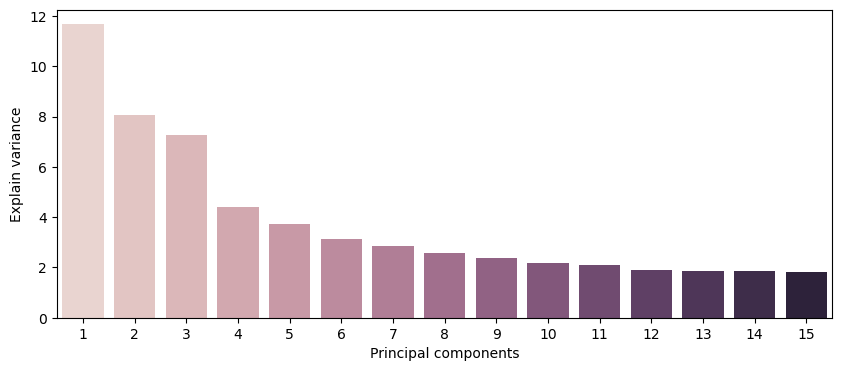

In [25]:
plt.figure(figsize=(10, 4))
pca=PCA(n_components=15)
pca.fit(X_scaled)
sns.barplot(x= np.arange(1,16) , y=pca.explained_variance_ratio_*100, hue=np.arange(1,16), legend=False)
plt.ylabel("Explain variance")
plt.xlabel("Principal components")

On observe de ce graphique qu'il y a deux coudes possibles, l'un à la deuxième composante et l'autre à la sixième composante. La première composante principale explique 11,66% de la variance totale, la deuxième en explique 8,05%, la troisième 7,27%, et à partir de la sixième composante principale, le pourcentage de variable expliquée devient inférieur à 3%. Les facteurs restants ont donc un apport d'information négligeable.

A ce graphique, on ajoute le graphique qui décrit l'évolution de la variance expliquée par les axes.

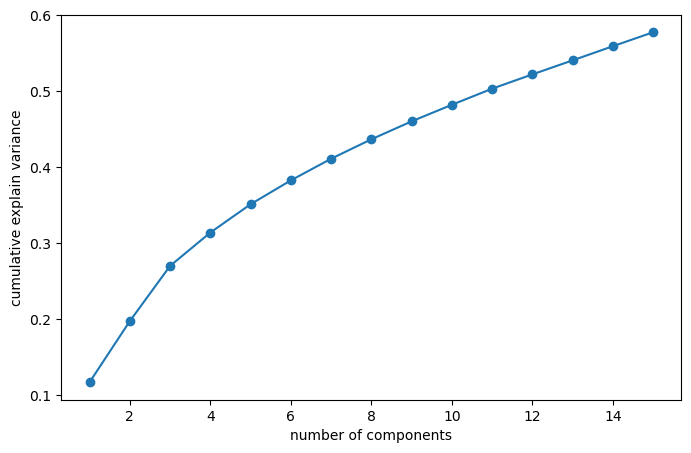

In [26]:
explained_variances=[]
for n in range(1,16):
    pca =PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,5))
plt.plot(range(1,16), explained_variances, marker='o')
plt.xlabel("number of components")
plt.ylabel("cumulative explain variance")
plt.show()

Ce graphique semble indiquer que le coude se trouve à la troisième composante principale. Cependant, Considerer trois composantes principales n'est pas une bonne idée car on perdrais le gain d'information substanciel qu'apporte les 2 composantes principales suivantes. Les 5 premières composantes principales expliquent environ 35% de l'information. Nous allons poursuivre cette recherche du nombre de composantes optimale en utilisant le test des bâtons brisés.

#### **Test des « bâtons brisés »**

Ce test est du à Frontier (1976) et Legendre-Legendre (1983). Il repose sur l’idée que si l’inertie totale était dispatchée aléatoirement sur les axes, la distribution des valeurs propres suivrait la loi des 
« bâtons brisés » (broken-stick). La valeur critique pour le choix des composantes principales s'écrit comme suit:
$$ b_{k} = \sum_{i=k}^{p} \frac 1 {i}$$

où p représente le nombre de variables.

In [23]:
baton_coef=[]
for i in np.arange(1,16):
    n=0
    for j in range(i,117):
        n=n+(1/j)
    baton_coef.append(n)

In [24]:
data1=pd.DataFrame(data=pca.explained_variance_, columns=["eigen_values"])
data1["b_k"]=baton_coef
data1.index=["PC{}".format(i) for i in np.arange(1,16)]
data1

,eigen_values,b_k
PC1,11.433010,5.335110
PC2,7.889850,4.335110
PC3,7.125282,3.835110
PC4,4.303626,3.501777
PC5,3.656622,3.251777
PC6,3.079037,3.051777
PC7,2.792477,2.885110
PC8,2.509312,2.742253
PC9,2.315227,2.617253
PC10,2.138628,2.506142


Avec ce test on peut retenir 5 composantes principales, car à la différence entre la valeur propre de la sixième composante principale et le seuil calculé est négligeable. Pour les composantes suivantes, les valeurs propres sont en dessous du seuil.

Nous retiendrons donc 5 composantes principales dans la suite.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Entrainement du modèle
</p>
<br/>

In [16]:
# training the model with 5 principal components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("Explain variance for each component :",pca.explained_variance_ratio_)
print("cumulated variance :",pca.explained_variance_ratio_.sum())

Explain variance for each component : [0.11666279 0.08050827 0.0727066  0.04391469 0.03731249]
cumulated variance : 0.3511048318033728


In [17]:
# coefficients of the principal components 
print("Composantes principales (coefficients) :")
table_coef=pd.DataFrame(pca.components_, columns=data.select_dtypes(exclude='category').columns)
table_coef.index=["PC{}".format(i+1) for i in np.arange(0,5)]
table_coef

Composantes principales (coefficients) :


,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,percentage_activities_23_0_1h_week,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
PC1,0.066023,0.075380,-0.004304,-2.710505e-20,0.117614,0.108084,0.151237,-0.005015,0.010848,0.006412,...,0.124556,0.124960,0.125143,0.096558,0.017135,-0.004208,0.089261,0.075793,0.014699,-0.085941
PC2,-0.008063,-0.011526,0.001866,0.000000e+00,0.064442,0.019719,0.024426,0.005472,-0.002838,0.010553,...,0.309994,0.305893,0.300151,0.033900,0.009572,0.012058,0.210167,-0.048971,0.004086,0.027052
PC3,-0.011089,-0.024572,0.029455,-1.110223e-16,-0.054100,0.053615,-0.048470,0.009290,-0.005749,0.014140,...,0.038576,0.037714,0.036979,0.021819,0.007797,-0.092366,0.025101,0.109215,0.007513,-0.111341
PC4,-0.012169,-0.023764,-0.102450,-5.551115e-17,-0.172160,-0.000519,-0.288067,-0.011698,-0.003291,-0.014431,...,0.053974,0.051357,0.047793,-0.081462,-0.001142,-0.133473,0.050539,0.034535,0.001306,-0.039158
PC5,0.096430,0.049827,0.418300,0.000000e+00,0.002723,-0.017382,0.017505,0.011653,0.012641,0.005018,...,-0.000583,-0.000302,0.000038,0.023226,0.006160,0.019295,-0.008328,0.023598,0.004648,-0.022514


In [18]:
# contributions of the principal components
loadings=pca.components_.T
eigenvalues=pca.explained_variance_
contributions=(loadings**2)*eigenvalues
contrib_percent=contributions/(eigenvalues.sum())*100
contrib_df=pd.DataFrame(contrib_percent, columns=["PC{}".format(i+1) for i in np.arange(0,5)])
contrib_df.index=data.columns
contrib_df.head()

,PC1,PC2,PC3,PC4,PC5
days_between_signup_and_first_activity,1.448413e-01,0.001491,2.546388e-03,1.852225e-03,0.098820
days_between_order_and_first_activity,1.888035e-01,0.003046,1.250339e-02,7.063180e-03,0.026384
days_between_first_and_last_activities,6.153829e-04,0.000080,1.796671e-02,1.312800e-01,1.859487
chapter_before_success_count,2.441159e-38,0.000000,2.552451e-31,3.854193e-32,0.000000
serie_before_success_count,4.596384e-01,0.095224,6.060847e-02,3.707144e-01,0.000079


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Interprétaion des axes principaux
</p>
<br/>

Seront considérées comme variables les plus contributrices à la formation d'un axe principale, les variables dont la contribution est supérieur à la contribution moyenne, c'est-à-dire: $$ 100/117 \approx 0.855 $$  

In [33]:
contrib1=pd.DataFrame(data=contrib_df["PC1"].sort_values(ascending=False)[:16].values, columns=["contribution"]) 
contrib1.index=contrib_df["PC1"].sort_values(ascending=False)[:16].index
contrib1["coefficient"]=table_coef[contrib1.index].iloc[0]
contrib1

,contribution,coefficient
notions_diverses_number_of_activities,1.464529,0.209943
mecanique_equipements_number_of_activities,1.421391,0.206828
prendre_quitter_vehicule_number_of_activities,1.404160,0.205570
autres_usagers_number_of_activities,1.403937,0.205554
route_number_of_activities,1.382899,0.204008
securite_number_of_activities,1.377518,0.203611
premiers_secours_number_of_activities,1.370145,0.203065
environnement_number_of_activities,1.323408,0.199572
conducteur_number_of_activities,1.258079,0.194584
score_pct__quantile__q_0_4,1.089173,0.181051


Les variables qui contribuent le plus à la construction de la première composante principale sont des variables qui renseigne sur le nombre d'activité effectuer par thématique pour le permis de conduire (*notions_diverses_number_of_activities*, *mecanique_equipements_number_of_activities*,*securite_number_of_activities*, *route_number_of_activities*, *prendre_quitter_vehicule_number_of_activities*, *autres_usagers_number_of_activities*,etc.) et les statistiques qui résultent des scores en pourcentage obtenus aux différents examens notamment les quantiles d'ordre 1, 2, 3 et 4 (*score_pct__quantile__q_0_1*, *score_pct__quantile__q_0_2*, *score_pct__quantile__q_0_3*, *score_pct__quantile__q_0_4*), et .... Cet axe résume le signal et/ou la corrélation qui existe entre le nombre d'activités effectués par thématique et la distribution du score au différents examens. On pourrait donc dire qu'il traduit l'**efficacité** des étudiants.

De plus, en analysant les coefficients de ces variables, ont constate qu'elles sont toutes positifs. Ainsi, un individu ayant un coefficient élevé sur cet axe, fait beaucoup d'activité sur les différentes thématiques d'apprentissage et a des scores élevés aux différents examens, ce qui signifie qu'il comprend bien ce qu'il fait.

In [34]:
contrib2=pd.DataFrame(data=contrib_df["PC2"].sort_values(ascending=False)[:9].values, columns=["contribution"]) 
contrib2.index=contrib_df["PC2"].sort_values(ascending=False)[:9].index
contrib2["coefficient"]=table_coef[contrib2.index].iloc[1]
contrib2

,contribution,coefficient
nb_weeks_weekly_study_objective_reached_90pct,2.248430,0.313139
nb_weeks_weekly_study_objective_reached_85pct,2.236727,0.312323
nb_weeks_weekly_study_objective_reached_95pct,2.236287,0.312293
nb_weeks_weekly_study_objective_reached_99pct,2.216164,0.310884
nb_weeks_weekly_study_objective_reached,2.208697,0.310360
nb_weeks_weekly_study_objective_reached_80pct,2.203486,0.309994
nb_weeks_weekly_study_objective_reached_75pct,2.145577,0.305893
nb_weeks_weekly_study_objective_reached_70pct,2.065778,0.300151
pct_study_objective_reached,1.012819,0.210167


Les variables qui contribuent fortement à la deuxième composante principale sont d'une part les variables qui renseignent sur le nombre de week-end où les objectifs d'étude hebdomadaire ont atteint un pourcentage donnée (90%,85%,95%,99%,75%,etc) et d'autre part les variables qui donnent le pourcentage d'objectifs d'études atteint le week-end (*nb_weeks_weekly_study_objective_reached*) et en dehors (*pct_study_objective_reached*). On pourrait dire que cet axe capture principalement l'information sur **l'intensité du travail personnel des étudiants**. 

De plus, le coefficient de toutes les variables qui contribuent le plus à la formation de l'axe 2 sont positifs. Donc, les individus qui ont un coefficient élevé et positif sur cet axe (se trouvant à une extrémité de l'axe) sont beaucoup investit personnellement dans la formation.

In [35]:
contrib3=pd.DataFrame(data=contrib_df["PC3"].sort_values(ascending=False)[:8].values, columns=["contribution"]) #pas terminé
contrib3.index=contrib_df["PC3"].sort_values(ascending=False)[:8].index
contrib3["coefficient"]=table_coef[contrib3.index].iloc[2]
contrib3 #pas terminé

,contribution,coefficient
score_pct__quantile__q_0_2,1.378471,-0.258006
score_pct__quantile__q_0_3,1.360804,-0.256348
score_pct__quantile__q_0_1,1.323760,-0.252834
score_pct__quantile__q_0_4,1.312995,-0.251804
score_pct__linear_trend__attr_intercept,1.145644,-0.235210
score_pct__c3__lag_1,1.128279,-0.233421
score_pct__c3__lag_2,1.074205,-0.227759
score_pct__c3__lag_3,1.014902,-0.221383


Les variables qui contribuent fortement à la 3e composante principale sont les variables qui caractérisent la distribution du score en pourcentage (notamment les quantiles et ...) aux différents examens renseignées pour chaque étudiant. On peut dire que cet axe capture l'information sur **la progression des étudiants en terme de résultats**. 

De plus, le fait que toutes ces variables ont un coefficient positif sur l'axe signifient qu'elles varient dans le même sens que l'axe. Donc un étudiant ayant un coefficient très faible (négatif) sur cet axe, obtient de mauvais résultats aux différents examens, ce qui traduit le fait qu'ils n'assimilent pas bien les connaissances.

In [36]:
contrib4=pd.DataFrame(data=contrib_df["PC4"].sort_values(ascending=False)[:6].values, columns=["contribution"]) #pas terminé
contrib4.index=contrib_df["PC4"].sort_values(ascending=False)[:6].index
contrib4["coefficient"]=table_coef[contrib4.index].iloc[3]
contrib4

,contribution,coefficient
score_pct__standard_deviation,1.347974,-0.328287
score_pct__variation_coefficient,1.201303,-0.309913
score_pct__minimum,1.165849,0.305305
nb_failed_series,1.098504,-0.296356
theory_activities_total,1.037623,-0.288027
session_count,0.984027,-0.280490


La mesure de la dispersion du score (*score_pct_standard_deviation*)  et la variation relative du score en pourcentage autour de la moyenne (*score_pct__variation_coefficient*)  contribuent majoritairement à la formation de la 4e composante principale. Aussi, le nombre d'examens échoués (*nb_failed_series*), le total d'activités théorique (*theory_activities_total*), le minimum du score en pourcentage (*score_pct_minimum*) , le nombre de session effectué (*session_count*), contribuent également fortement à la formation de cet axe. Cette composante semble donc être fortement influencé par des variables liées à **la performance académique, à la régularité aux examens**. 

De l'analyse des coefficients de ces variables, on observe que les variables qui donne le minimum du score en pourcentage et la dernière localisation du minimum du score ont des coefficients négatifs. On pourrait donc dire que les individus ayant un score élevé sur cette composante sont succeptibles d'avoir des performances très irrégulières (caractérisées par une dispersion élevée des scores), rencontrent régulièrement des échecs et mettent du temps à assimiler les compétences (nombre de series échoué élevé), ce qui impliquent qu'ils doivent faire plus d'activités, d'examen et de session (**theory_activities_total**,**session_count**).

In [37]:
contrib5=pd.DataFrame(data=contrib_df["PC5"].sort_values(ascending=False)[:4].values, columns=["contribution"]) #pas terminé
contrib5.index=contrib_df["PC5"].sort_values(ascending=False)[:4].index
contrib5["coefficient"]=table_coef[contrib5.index].iloc[4]
contrib5

,contribution,coefficient
minutes_between_sessions_max,2.023320,0.436339
days_between_first_and_last_activities,1.861276,0.418502
minutes_between_sessions_avg,1.572999,0.384730
minutes_between_sessions_std,1.467648,0.371623


Le maximum (*minutes_between_sessions_max*), la moyenne (*minutes_between_sessions_avg*), l'écart type (*minutes_between_sessions_std*) qui mesurent **la régularité et la concentration des sessions d'apprentissage** contribuent fortement à la formation de la cinquième composante principale. Egalement, le nombre de jour entre la première activité et la dernière activité (*days_between_first_and_last_activities*) qui mesure **l'engagement totale de l'étudiant dans la formation**, contribue fortement à la formation de cet axe.

Les coefficients de ces variables sont tous positifs, ce qui signifie que la composante varie dans le même sens que ces variables. Donc, les individus ayant un coefficient positif élevé sur cet axe (se situant à une extrémité de l'axe) ont une formation étalée sur une longue période, des sessions d'apprentissage très irrégulières, avec de longues périodes d'inactivité entre chaque session (un écart type élevé suggère des sessions très espacées dans le temps, et une médiane élevée indique des sessions moins fréquentes).

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Graphique des individus
</p>
<br/>

Nous allons représenter les 20 premiers individus de la base sur les différents axes factorielles afin de voir concrètement ce qu'ils traduisent.

In [ ]:
x_pca=X_pca[1:20,:]

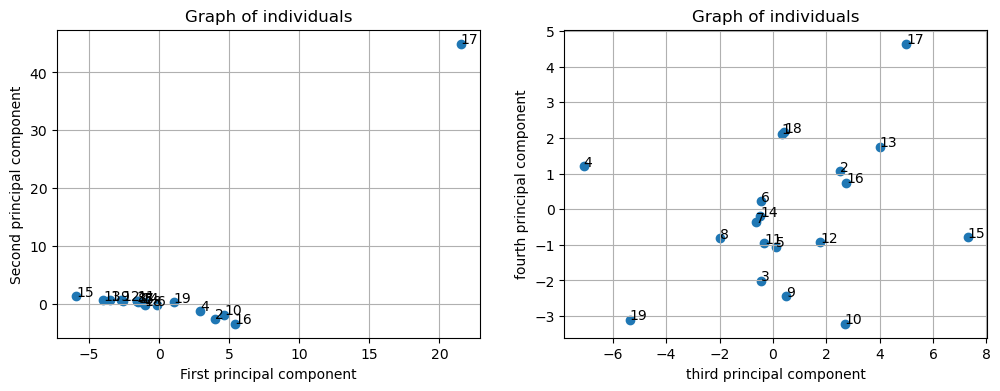

In [ ]:
plt.figure(figsize=(12, 4))
# construction of the first graph
plt.subplot(1, 2, 1)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 1]))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Graph of individuals")
plt.grid(True)

# construction of the second graph
plt.subplot(1, 2, 2)
plt.scatter(x_pca[:, 2], x_pca[:, 3])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 2], x_pca[i, 3]))
plt.xlabel("third principal component")
plt.ylabel("fourth principal component")
plt.title("Graph of individuals")
plt.grid(True)

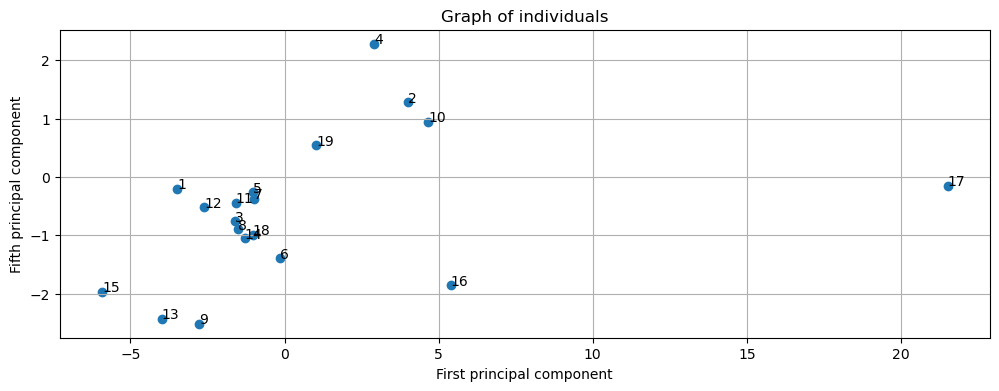

In [ ]:
#construction of the third graph 
plt.figure(figsize=(12, 4))
plt.scatter(x_pca[:, 0], x_pca[:, 4])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 4]))
plt.xlabel("First principal component")
plt.ylabel("Fifth principal component")
plt.title("Graph of individuals")
plt.grid(True)

Considérons l'individu numéro 17. Il a un coefficient élevé sur les deux premiers axes factoriels, ce qui signifie qu'il fait un grand nombre d'activités par thématique d'apprentissage et à de bons scores aux différentes session d'évaluation. De plus il a un coefficient négatif relativement faible sur le reste des axes factoriels, ce qui signifie qu'il a des scores peu dispersé autour de la moyenne, il a de bonne performance académique et est plus ou moins régulier aux sessions d'apprentissage. En bref, c'est un bon élève.

Par contre, l'individu numéro 15 a un coefficient négatif sur le premier axe factoriel, proche de 0 sur le deuxième axe factoriel et négatif sur le troisième axe factoriel ce qui signifie qu'il ne fait relativement peu d'activités par thématique d'apprentissage et n'a pas de bonnes performances académique. De plus, il a un coefficient négatif sur le cinquième axe factoriel et proche de 0 sur le quatrième et sixième axe factoriel, ce qui traduit le fait qu'il est moin régulier aux examens et ses sessions d'apprentissage sont moins concentrées.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Erreur de reconstruction
</p>
<br/>

In [19]:
from sklearn.metrics import mean_squared_error
# reconstruction of the data with inverse_transform
X_reconstructed = pca.inverse_transform(X_pca)

# Calculer l'erreur de reconstruction (norme Euclidienne)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)

In [20]:
print(f"Erreur de reconstruction : {reconstruction_error}")

Erreur de reconstruction : 0.543519029771535


In [27]:
# Calcul de l'information mutuelle entre les données originales et reconstruites
mi_scores = [mutual_info_regression(X_scaled[:, i].reshape(-1, 1), X_reconstructed[:, i]) for i in range(X_scaled.shape[1])]
#mean_mi = np.mean([np.mean(score) for score in mi_scores])
#print(f"Information mutuelle moyenne : {mean_mi:.4f}")
total_mi = np.sum(mi_scores)
print(f"Information mutuelle totale : {total_mi:.4f}")

Information mutuelle totale : 30.0488


In [29]:
from scipy.stats import entropy
def normalized_mutual_information(X_scaled, X_reconstructed):
    H_X = np.sum([entropy(np.histogram(X_scaled[:, i], bins=20)[0] + 1e-10) for i in range(X_scaled.shape[1])])  # Entropie totale
    I_X_Xhat = total_mi # Info mutuelle
    return I_X_Xhat / H_X  # Ratio d'info conservée

# Calcul du taux d'information mutuelle conservée
nmi = normalized_mutual_information(X_scaled, X_reconstructed)
print(f"Part d'information conservée (normalisée) : {nmi:.2%}")

Part d'information conservée (normalisée) : 31.77%


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
2- Analyse Factorielle des Composantes Mixtes (FAMD) </u>
</p>
<br/>

Exportation des données sous un format reconnu par R

In [ ]:

# Suppression des variables de type date
base_Edu_cleaned = base_Edu.select_dtypes(exclude=['datetime64'])

# Séparation des variables numériques et catégorielles
numeric_data = base_Edu_cleaned.select_dtypes(include=['number'])
category_data = base_Edu_cleaned.select_dtypes(include=['category'])

# Exportation des variables numériques vers un fichier Parquet
numeric_output_path = r"C:\Users\damso\Documents\data\data_num.parquet"
numeric_data.to_parquet(numeric_output_path, index=False)

# Exportation des variables catégorielles vers un fichier Parquet
category_output_path = r"C:\Users\damso\Documents\data\category_data.parquet"
category_data.to_parquet(category_output_path, index=False)

In [43]:
print("nombre de variables numerique: ",numeric_data.shape[1])
print("nombre de variables catégorielles", category_data.shape[1])

nombre de variables numerique:  118
nombre de variables catégorielles 254



<br/>
<p>
Après suppression des variables de type date et de la variable unique_learner_id , nous n'avons plus que 371 variables, dont 254 catégorielles(factor) et 117 numériques,  auquelles nous appliquerons la FAMD depuis R studio puis, nous interprétrons les résultats(variance expliquée, individu, variables).
</p>
<br/>

In [44]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le chemin où sont stockés les fichiers exportés depuis R
export_path = r"C:/Users/damso/Documents/Projet_Statistique/"

# Liste des fichiers à importer 

coord_ind_total = pd.read_csv("C:/Users/damso/Documents/data/result_ind_coord.csv")
coord_var_total = pd.read_csv( "C:/Users/damso/Documents/data/result_var_coord.csv")
variance_total = pd.read_csv("C:/Users/damso/Documents/data/result_variance.csv")

# Affichage des informations importantes

print(f"\n==== Résultats pour famd0 ====")
print(f"Nombre d'individus: {coord_ind_total.shape[0]}")
print(f"Nombre de variables: {coord_var_total.shape[0]}")
print(f"Nombre de composantes: {variance_total.shape[0]}")
print("Pourcentage de variance expliquée par chaque composante:\n", variance_total.iloc[:, 2])



==== Résultats pour famd0 ====
Nombre d'individus: 200000
Nombre de variables: 371
Nombre de composantes: 20
Pourcentage de variance expliquée par chaque composante:
 0     20.413033
1      2.524357
2      2.003599
3      1.746728
4      1.533339
5      1.007631
6      0.913385
7      0.868160
8      0.845962
9      0.837021
10     0.826354
11     0.809997
12     0.799562
13     0.781710
14     0.775136
15     0.744219
16     0.728571
17     0.716312
18     0.713825
19     0.699645
Name: percentage of variance, dtype: float64


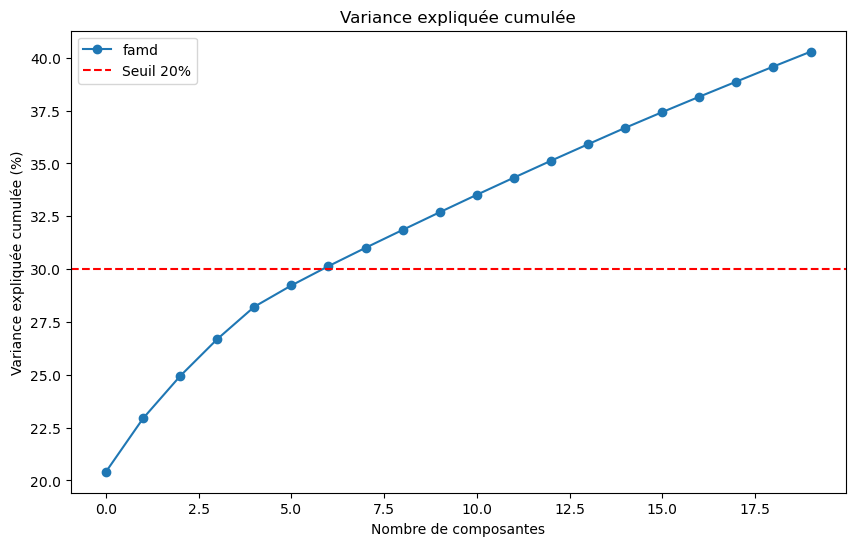

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(variance_total.index, variance_total.iloc[:, 2].cumsum(), marker='o', label="famd")

plt.axhline(y=30, color='r', linestyle='--', label="Seuil 20%")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée (%)")
plt.title("Variance expliquée cumulée")
plt.legend()
plt.show()


 <b> les deux premières  dimensions, qui contiennent des informations sur 372 variables(de "days_between_signup_and_first_activity" à "unique_learner_id") et expliquent  22,93% environ de la variance totale. à partir de 6 et 7 composantes nous avons 30% de variance expliquée.</b>

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Erreur de reconstruction
</p>
<br/>

In [46]:
variance_total.iloc[:, 2].sum()

40.28854731449993


---

### <u>Test des bâtons brisés </u>: explication

Le test des bâtons brisés est un critère qui permet de déterminer combien de dimensions (ou composantes principales) sont statistiquement significatives dans une analyse factorielle (ACP, FAMD, etc.). 

Voici comment il fonctionne :

1. **Hypothèse aléatoire** :
   - Suppose que l'inertie totale (somme des valeurs propres) est répartie uniformément et aléatoirement sur toutes les dimensions.

2. **Valeurs théoriques (bâtons brisés)** :
   - La valeur théorique pour chaque dimension est calculée comme : <br/>
     Bâton brisé pour la dimension k  =1/p x ∑1/j ,  j allant de k à p
     Où p est le nombre total de dimensions, et k est la dimension en cours.
   - Cela donne une distribution décroissante.

3. **Comparaison** :
   - Si une valeur propre observée est supérieure ou égale à la valeur théorique correspondante (bâton brisé), cette dimension est significative et doit être conservée.

---


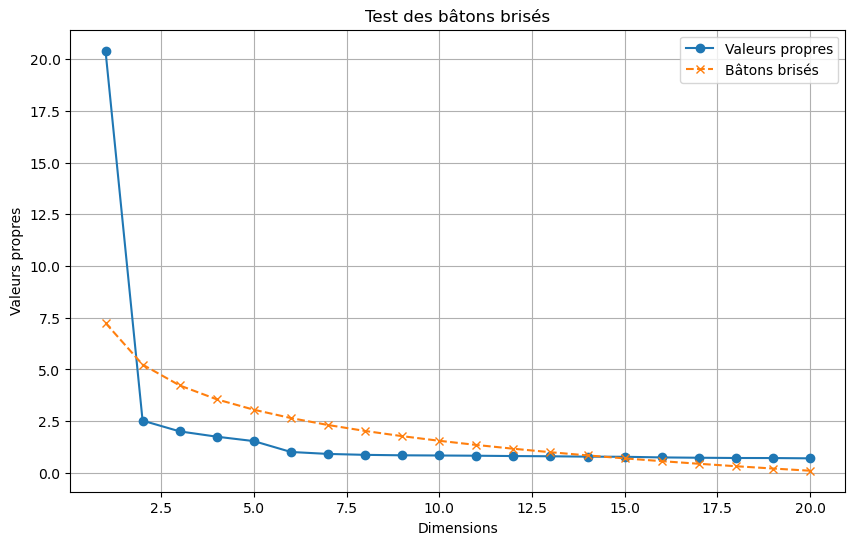

Nombre optimal de dimensions retenues : 7


In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de valeurs propres issues d'une FAMD
# Remplacez-les par vos vraies valeurs propres
valeurs_propres = np.array(variance_total.iloc[:, 2])   # Exemple
n_dimensions = len(valeurs_propres)

# Somme totale des valeurs propres
somme_totale = sum(valeurs_propres)

# Calcul des bâtons brisés
batons_brises = [sum(1 / np.arange(k, n_dimensions + 1)) / n_dimensions * somme_totale for k in range(1, n_dimensions + 1)]

# Tracer la courbe des valeurs propres et des bâtons brisés
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_dimensions + 1), valeurs_propres, marker='o', label='Valeurs propres')
plt.plot(range(1, n_dimensions + 1), batons_brises, marker='x', label='Bâtons brisés', linestyle='--')
plt.xlabel('Dimensions')
plt.ylabel('Valeurs propres')
plt.title('Test des bâtons brisés')
plt.legend()
plt.grid()
plt.show()

# Déterminer le nombre optimal de dimensions
dimensions_retenues = sum(valeurs_propres > batons_brises)
print(f"Nombre optimal de dimensions retenues : {dimensions_retenues}")

In [13]:


# Affichage du résultat
print(f"la variance totale expliquée par 7 axes est :",variance_total.iloc[:, 2][:7].sum())


la variance totale expliquée par 7 axes est : 30.142071039011523


Nous conserverons finalement les 7 premiers axes qui conservent <b>30,14%</b> de l'information initiale de Base_Edu
<br/>
<br/>

## Distribution des individus dans les deux premières dimensions 

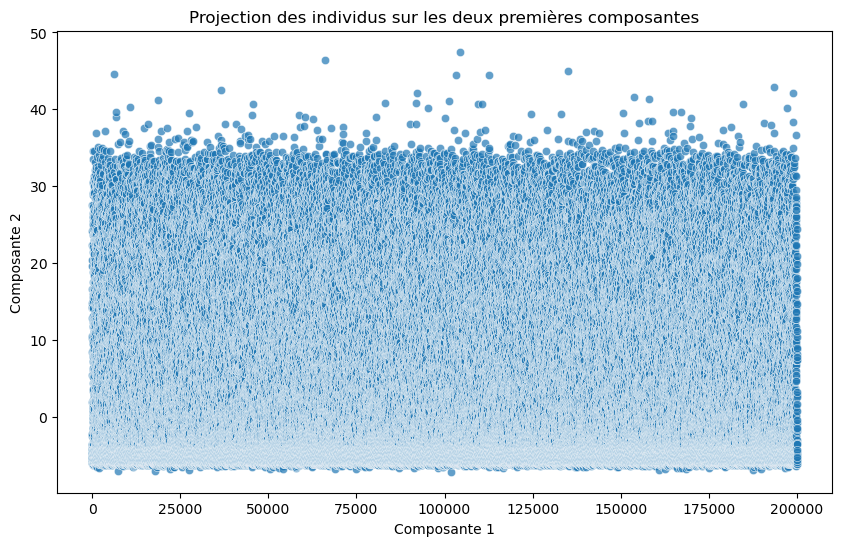

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total.iloc[:, 0], 
                y=coord_ind_total.iloc[:, 1], 
                alpha=0.7)
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

<br/>
### 1. **Projection des individus**
Les graphiques montrent la projection d'individus sur les premières composantes principales, ce qui permet de visualiser la structure sous-jacente des données. Chaque point représente un individu, et leur disposition dans le plan révèle des tendances et des regroupements.

### 2. **Dispersion des points**
- **Premier graphique :** Les points sont relativement dispersés, indiquant une diversité dans les données. La forme globale peut suggérer des groupes potentiels.

### 3. **Interprétation des axes**
Les axes des graphiques (composantes 1, 2, 3, etc.) représentent des combinaisons linéaires des variables originales. L'interprétation de ces axes dépend des variables qui les composent. Une analyse plus approfondie des contributions des variables aux composantes peut révéler quelles variables sont les plus influentes dans la formation de ces groupes.
<br/>
En résumé, cette série de graphiques permet de visualiser la structure des données après réduction de dimensions, mettant en lumière des tendances et des relations potentielles parmi les individus observés. 
<br/>
<br/>


In [49]:
coord_var_total.head()

,Unnamed: 0,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,...,Dim.11,Dim.12,Dim.13,Dim.14,Dim.15,Dim.16,Dim.17,Dim.18,Dim.19,Dim.20
0,days_between_signup_and_first_activity,0.060469,1.340585e-02,3.306686e-03,1.085803e-03,2.444349e-03,1.240105e-03,1.193800e-04,1.771733e-03,1.381545e-02,...,3.177842e-02,3.311650e-04,3.279790e-03,2.572843e-03,5.587823e-06,7.593291e-03,1.049336e-04,4.877940e-04,7.379975e-04,2.196004e-02
1,days_between_order_and_first_activity,0.067894,2.086293e-02,4.222174e-03,9.943607e-04,6.897291e-03,1.335984e-03,8.946057e-05,9.799050e-04,8.288031e-03,...,1.276525e-02,4.496465e-04,1.499185e-03,7.191965e-03,1.769685e-05,1.093170e-02,4.562235e-06,6.764387e-04,1.667384e-03,3.421375e-02
2,days_between_first_and_last_activities,0.000220,2.309762e-03,4.489899e-03,3.547507e-04,5.859962e-05,3.124564e-02,4.207405e-02,7.772785e-02,6.360829e-02,...,2.834759e-01,9.961686e-03,5.141576e-03,2.717504e-02,2.790642e-04,3.122091e-03,3.795098e-04,5.212192e-06,1.785804e-03,1.602211e-02
3,chapter_before_success_count,0.000000,6.876126e-30,6.961260e-31,2.973709e-31,9.709183e-31,7.488622e-32,6.095622e-31,1.746458e-32,1.487966e-30,...,1.535348e-32,2.000945e-31,9.774483e-31,4.656447e-32,1.938083e-32,1.167605e-32,1.768873e-33,4.429422e-32,7.731535e-31,2.187747e-32
4,serie_before_success_count,0.024040,7.142193e-02,1.017187e-01,6.211473e-02,2.905303e-02,7.094549e-02,5.543272e-02,1.890330e-02,4.853872e-04,...,3.392442e-03,2.695131e-03,3.304848e-03,5.768196e-04,1.445907e-04,1.089276e-03,8.870997e-04,3.230545e-04,5.026132e-06,3.976851e-04


Nous allons à présent exploiter les informations données par les variables contribuants à chaque dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Informations sur les dimensions(composantes) conservées
</p>
<br/>


In [50]:

# Trier les variables par leurs coefficients dans Dim.1 (ordre décroissant)
coord_var_total_sorted = coord_var_total.sort_values(by='Dim.1', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.1
top_20_dim1_variables = coord_var_total_sorted[['Unnamed: 0', 'Dim.1']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim1_variables.columns = ['Variable', 'Coefficient_Dim1']

# Afficher les résultats
print(top_20_dim1_variables)

                                            Variable  Coefficient_Dim1
167   choice_00_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667377
168   choice_01_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667368
166  is_correct_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667237
157   choice_00_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615346
158   choice_01_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615320
159   choice_02_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615255
160   choice_03_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615216
156  is_correct_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615216
256  is_correct_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611385
260   choice_03_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611385
258   choice_01_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611145
259   choice_02_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611140
257   choice_00_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611129
153   

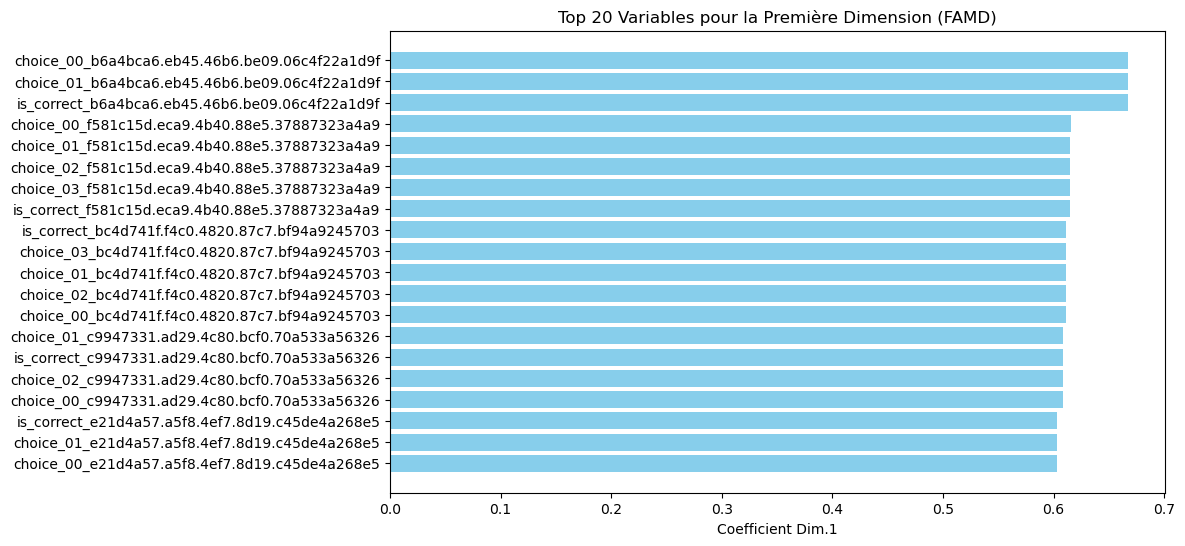

In [51]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.1
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim1_variables['Variable'], top_20_dim1_variables['Coefficient_Dim1'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.1')
plt.title('Top 20 Variables pour la Première Dimension (FAMD)')
plt.show()

Pour donner un sens à la première dimension de notre FAMD, Nous devons examiner les variables qui contribuent le plus à cette dimension (les variables avec les plus grands coefficients). Ces variables nous donnent des indices sur la signification ou l'interprétation principale de cette dimension.

---

### Étapes pour interpréter la dimension 1 :

1. **Identification des variables dominantes** :
   - Dans le graphique, les variables avec les plus grands coefficients dans la première dimension sont des variables comme `choice_00`, `choice_01`, `is_correct`, etc.

2. **Analyse du contexte des variables** :
   - Si ces variables sont liées à des choix ou des réponses correctes/incorrectes dans le cadre d'une analyse liée à l'accidentologie, elles pourraient représenter un **facteur de prise de décision ou de comportement**.

3. **Interprétation du sens global** :
   - Si les variables dominantes concernent principalement des choix et des résultats ("correct" ou "incorrect"), la première dimension pourrait refléter un **axe décisionnel ou comportemental**, comme par exemple :
     - "Prise de décision correcte/incorrecte".
     - "Comportement face à une situation d'accident".
     - "Réactions face à des scénarios liés à l'accidentologie".


### Exemple d'interprétation dans votre cas :
Puisque la base de données initiale est liée à l'accidentologie et que les variables sont associées à des réponses ou comportements face à des scénarios donnés, la dimension 1 semble capturer une distinction entre des choix ou des comportements corrects et incorrects.

### Proposition de nom pour la première dimension :
<u>- **"Prise de décision face aux situations d'accident"**.</u>

Ce nom reflète que cette dimension pourrait regrouper des variables associées à la qualité ou au type de comportement observé dans un contexte d'accident.

In [ ]:

# Trier les variables par leurs coefficients dans Dim.2 (ordre décroissant)
coord_var_total_sorted2 = coord_var_total.sort_values(by='Dim.2', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.2
top_20_dim2_variables = coord_var_total_sorted2[['Unnamed: 0', 'Dim.2']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim2_variables.columns = ['Variable', 'Coefficient_Dim2']

# Afficher les résultats
print(top_20_dim2_variables)



                                          Variable  Coefficient_Dim2
97                      score_pct__quantile__q_0_2          0.437458
98                      score_pct__quantile__q_0_3          0.433994
99                      score_pct__quantile__q_0_4          0.421394
96                      score_pct__quantile__q_0_1          0.420571
93                            score_pct__c3__lag_1          0.394077
94                            score_pct__c3__lag_2          0.371417
95                            score_pct__c3__lag_3          0.352788
100        score_pct__linear_trend__attr_intercept          0.347135
53           notions_diverses_number_of_activities          0.224893
51      mecanique_equipements_number_of_activities          0.214398
57   prendre_quitter_vehicule_number_of_activities          0.211183
61                   securite_number_of_activities          0.208938
43             autres_usagers_number_of_activities          0.208396
55           premiers_secours_numb

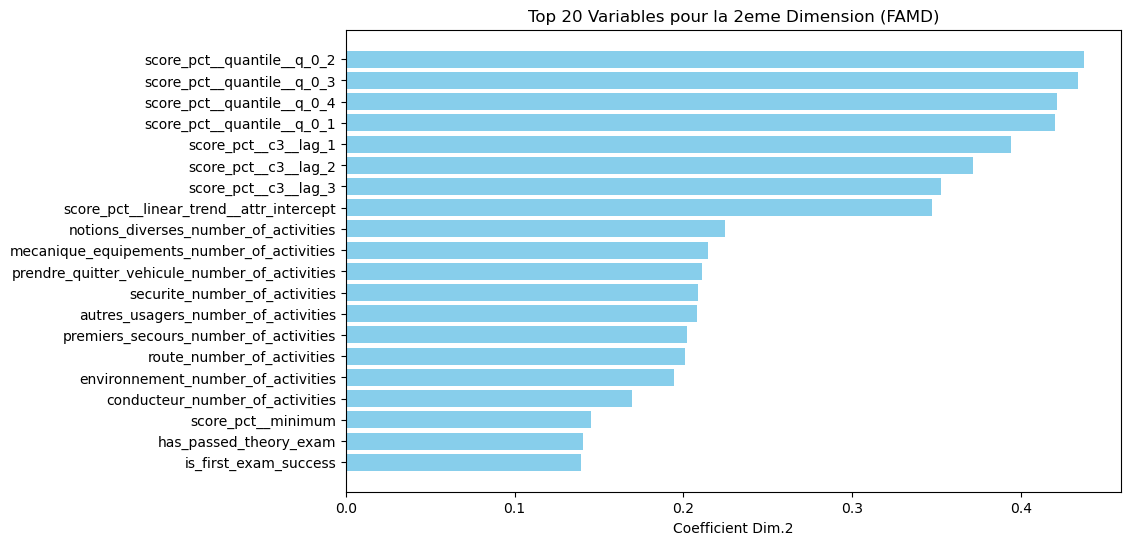

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.2
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim2_variables['Variable'], top_20_dim2_variables['Coefficient_Dim2'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.2')
plt.title('Top 20 Variables pour la 2eme Dimension (FAMD)')
plt.show()

---

### Dimension 2 :
- **Variables dominantes** : `score_pct_quantile`, `score_pct_linear_trend_attr_intercept`, `notions_diverses_number_of_activities`, `mecanique_equipements_number_of_activities`.
- **Interprétation** : Cette dimension semble capturer la performance et la diversité des activités réalisées dans le cadre de l'apprentissage.
- **Nom suggéré** : **"Performance et diversité des activités"**.


---

In [ ]:

# Trier les variables par leurs coefficients dans Dim.3 (ordre décroissant)
coord_var_total_sorted3 = coord_var_total.sort_values(by='Dim.3', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.3
top_20_dim3_variables = coord_var_total_sorted3[['Unnamed: 0', 'Dim.3']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim3_variables.columns = ['Variable', 'Coefficient_Dim3']

# Afficher les résultats
print(top_20_dim3_variables)



                                          Variable  Coefficient_Dim3
53           notions_diverses_number_of_activities          0.270591
57   prendre_quitter_vehicule_number_of_activities          0.268102
43             autres_usagers_number_of_activities          0.264001
51      mecanique_equipements_number_of_activities          0.262965
55           premiers_secours_number_of_activities          0.262490
61                   securite_number_of_activities          0.260980
59                      route_number_of_activities          0.257077
49              environnement_number_of_activities          0.247719
47                 conducteur_number_of_activities          0.230728
45       circulation_routiere_number_of_activities          0.152161
106  nb_weeks_weekly_study_objective_reached_85pct          0.136630
105  nb_weeks_weekly_study_objective_reached_90pct          0.136311
107  nb_weeks_weekly_study_objective_reached_80pct          0.135153
104  nb_weeks_weekly_study_objecti

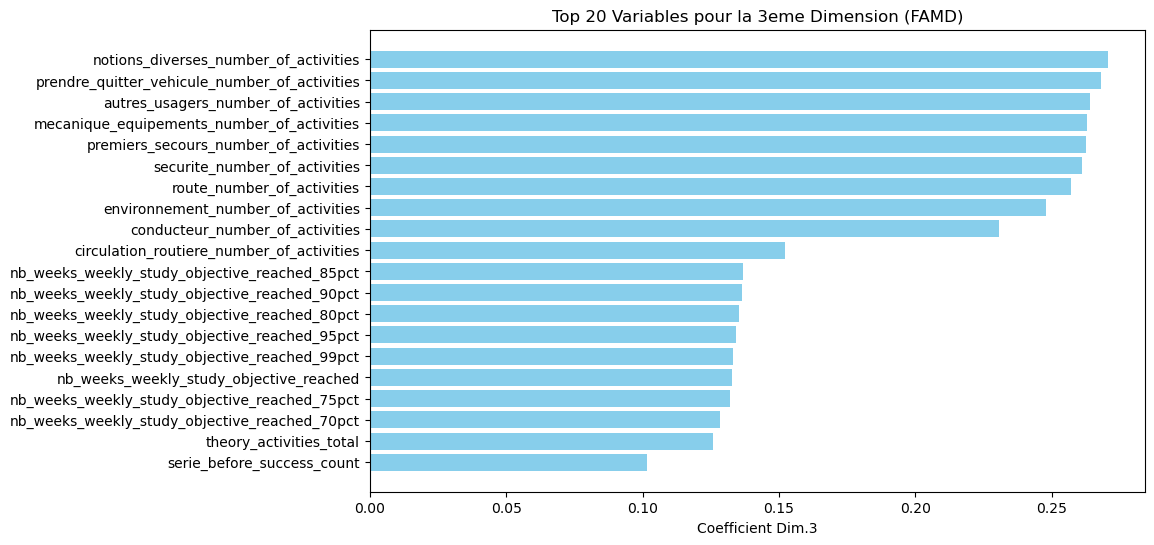

In [80]:

# Tracer un graphique en barres pour les variables de Dim.3
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim3_variables['Variable'], top_20_dim3_variables['Coefficient_Dim3'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.3')
plt.title('Top 20 Variables pour la 3eme Dimension (FAMD)')
plt.show()

---
### Dimension 3 :
- **Variables dominantes** : `notions_diverses_number_of_activities`, `prendre_quitter_vehicule_number_of_activities`, `mecanique_equipements_number_of_activities`, `premiers_secours_number_of_activities`.
- **Interprétation** : Cette dimension semble représenter les types d'activités spécifiques réalisées, notamment celles relatives à la sécurité ou à la mécanique.
- **Nom suggéré** : **"Type d'activités réalisées"**.
---

In [81]:

# Trier les variables par leurs coefficients dans Dim.4 (ordre décroissant)
coord_var_total_sorted4 = coord_var_total.sort_values(by='Dim.4', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.4
top_20_dim4_variables = coord_var_total_sorted4[['Unnamed: 0', 'Dim.4']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim4_variables.columns = ['Variable', 'Coefficient_Dim4']

# Afficher les résultats
print(top_20_dim4_variables)



                                          Variable  Coefficient_Dim4
105  nb_weeks_weekly_study_objective_reached_90pct          0.591367
104  nb_weeks_weekly_study_objective_reached_95pct          0.589220
106  nb_weeks_weekly_study_objective_reached_85pct          0.587639
103  nb_weeks_weekly_study_objective_reached_99pct          0.584026
102        nb_weeks_weekly_study_objective_reached          0.581888
107  nb_weeks_weekly_study_objective_reached_80pct          0.578145
108  nb_weeks_weekly_study_objective_reached_75pct          0.562656
109  nb_weeks_weekly_study_objective_reached_70pct          0.540811
113                    pct_study_objective_reached          0.268144
53           notions_diverses_number_of_activities          0.208361
43             autres_usagers_number_of_activities          0.206897
59                      route_number_of_activities          0.203826
57   prendre_quitter_vehicule_number_of_activities          0.202360
55           premiers_secours_numb

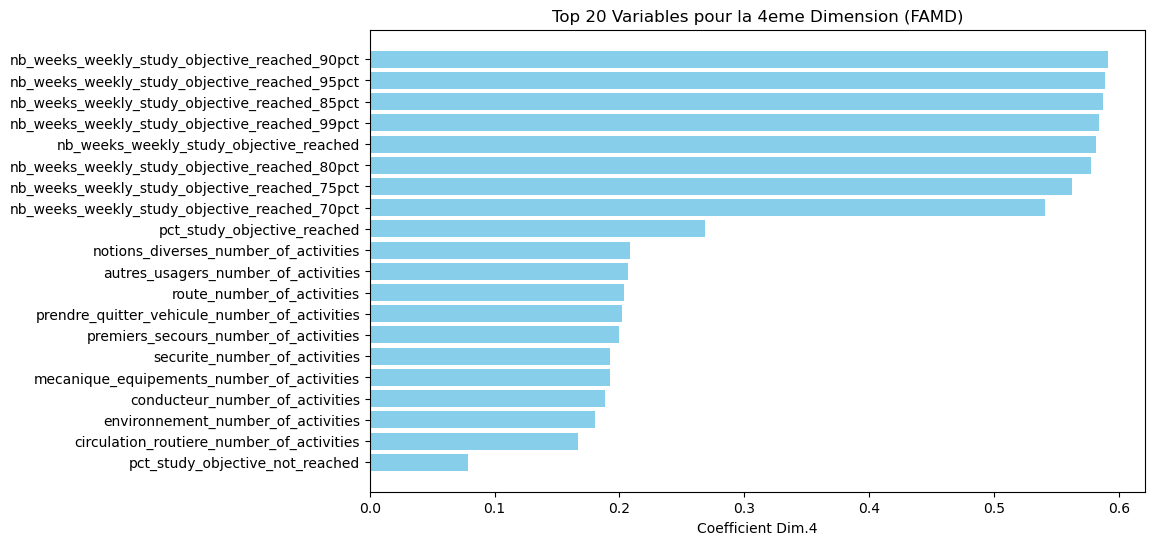

In [82]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.4
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim4_variables['Variable'], top_20_dim4_variables['Coefficient_Dim4'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.4')
plt.title('Top 20 Variables pour la 4eme Dimension (FAMD)')
plt.show()


---

### Dimension 4 :
- **Variables dominantes** : `nb_weeks_weekly_study_objective_reached`, `pct_study_objective_reached`, `notions_diverses_number_of_activities`, `route_number_of_activities`.
- **Interprétation** : Cette dimension semble mesurer l'engagement dans l'apprentissage sur plusieurs semaines et la réalisation des objectifs.
- **Nom suggéré** : **"Engagement et réalisation des objectifs"**.

---


In [83]:

# Trier les variables par leurs coefficients dans Dim.5 (ordre décroissant)
coord_var_total_sorted5 = coord_var_total.sort_values(by='Dim.5', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.5
top_20_dim5_variables = coord_var_total_sorted5[['Unnamed: 0', 'Dim.5']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim5_variables.columns = ['Variable', 'Coefficient_Dim5']

# Afficher les résultats
print(top_20_dim5_variables)



                                          Variable  Coefficient_Dim5
98                      score_pct__quantile__q_0_3          0.315201
99                      score_pct__quantile__q_0_4          0.311769
97                      score_pct__quantile__q_0_2          0.308312
93                            score_pct__c3__lag_1          0.282182
96                      score_pct__quantile__q_0_1          0.280718
94                            score_pct__c3__lag_2          0.278363
95                            score_pct__c3__lag_3          0.269744
100        score_pct__linear_trend__attr_intercept          0.232401
104  nb_weeks_weekly_study_objective_reached_95pct          0.150493
105  nb_weeks_weekly_study_objective_reached_90pct          0.149958
103  nb_weeks_weekly_study_objective_reached_99pct          0.149713
102        nb_weeks_weekly_study_objective_reached          0.149351
106  nb_weeks_weekly_study_objective_reached_85pct          0.147772
107  nb_weeks_weekly_study_objecti

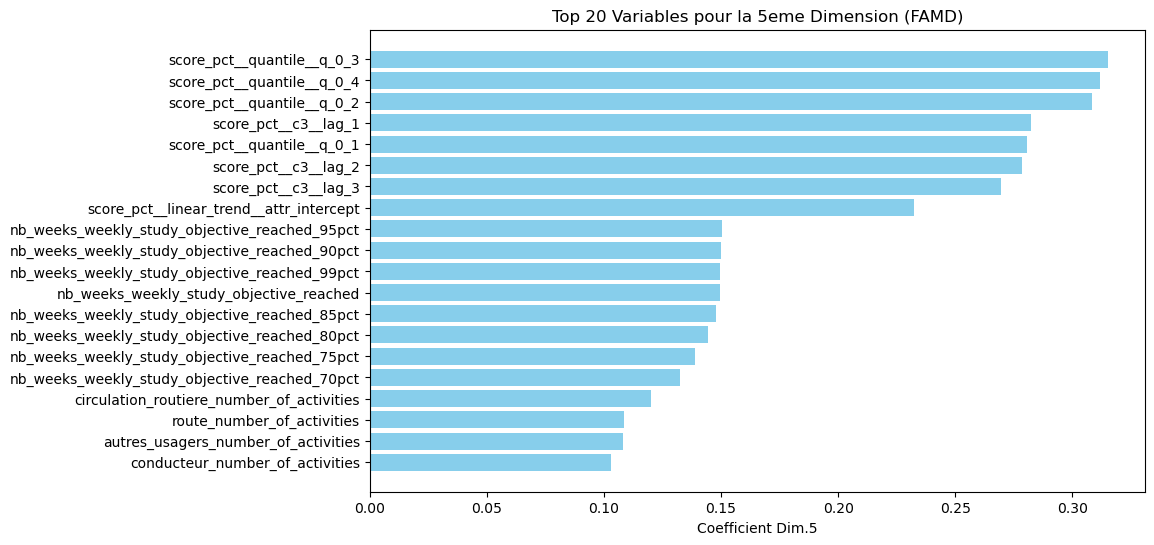

In [84]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.5
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim5_variables['Variable'], top_20_dim5_variables['Coefficient_Dim5'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.5')
plt.title('Top 20 Variables pour la 5eme Dimension (FAMD)')
plt.show()


---

### Dimension 5 :
- **Variables dominantes** : `score_pct_quantile`, `nb_weeks_weekly_study_objective_reached`, `circulation_routiere_number_of_activities`.
- **Interprétation** : Cette dimension semble relier la progression des scores à la réalisation d'activités sur la route.
- **Nom suggéré** : **"Progression des scores et activités sur la route"**.

---


In [85]:

# Trier les variables par leurs coefficients dans Dim.6 (ordre décroissant)
coord_var_total_sorted6 = coord_var_total.sort_values(by='Dim.6', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.6
top_20_dim6_variables = coord_var_total_sorted6[['Unnamed: 0', 'Dim.6']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim6_variables.columns = ['Variable', 'Coefficient_Dim6']

# Afficher les résultats
print(top_20_dim6_variables)



                                            Variable  Coefficient_Dim6
92                                score_pct__minimum          0.252310
85                     score_pct__standard_deviation          0.251331
86                  score_pct__variation_coefficient          0.246868
74                                     session_count          0.184321
6                            theory_activities_total          0.172717
76                                  nb_failed_series          0.159903
289   choice_02_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.140113
290   choice_03_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.139919
286  is_correct_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.139919
288   choice_01_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.136779
82                        score_pct__mean_abs_change          0.131728
81                                    nb_exam_series          0.088067
96                        score_pct__quantile__q_0_1          0.085691
4     

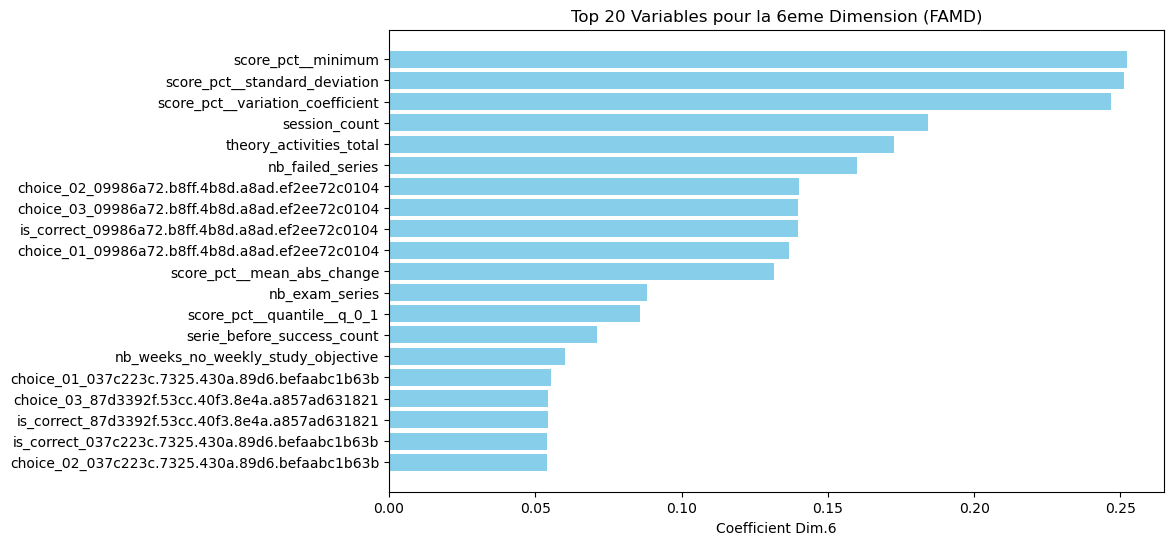

In [86]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.6
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim6_variables['Variable'], top_20_dim6_variables['Coefficient_Dim6'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.6')
plt.title('Top 20 Variables pour la 6eme Dimension (FAMD)')
plt.show()


---

### Dimension 6 :
- **Variables dominantes** : `score_pct_minimum`, `score_pct_standard_deviation`, `theory_activities_total`, `is_correct`, `nb_failed_series`.
- **Interprétation** : Cette dimension semble refléter la variabilité des performances, les échecs éventuels et le volume d'activités théoriques réalisées.
- **Nom suggéré** : **"Variabilité des performances et activités théoriques"**.

---


In [16]:

# Trier les variables par leurs coefficients dans Dim.7 (ordre décroissant)
coord_var_total_sorted7 = coord_var_total.sort_values(by='Dim.7', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.7
top_20_dim7_variables = coord_var_total_sorted7[['Unnamed: 0', 'Dim.7']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim7_variables.columns = ['Variable', 'Coefficient_Dim7']

# Afficher les résultats
print(top_20_dim7_variables)



                                            Variable  Coefficient_Dim7
289   choice_02_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565707
290   choice_03_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565654
286  is_correct_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565654
288   choice_01_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.538012
86                  score_pct__variation_coefficient          0.109278
85                     score_pct__standard_deviation          0.104391
92                                score_pct__minimum          0.100484
287   choice_00_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.100107
4                         serie_before_success_count          0.055433
117                            is_first_exam_success          0.053924
120                           has_passed_theory_exam          0.052191
76                                  nb_failed_series          0.050130
2             days_between_first_and_last_activities          0.042074
74    

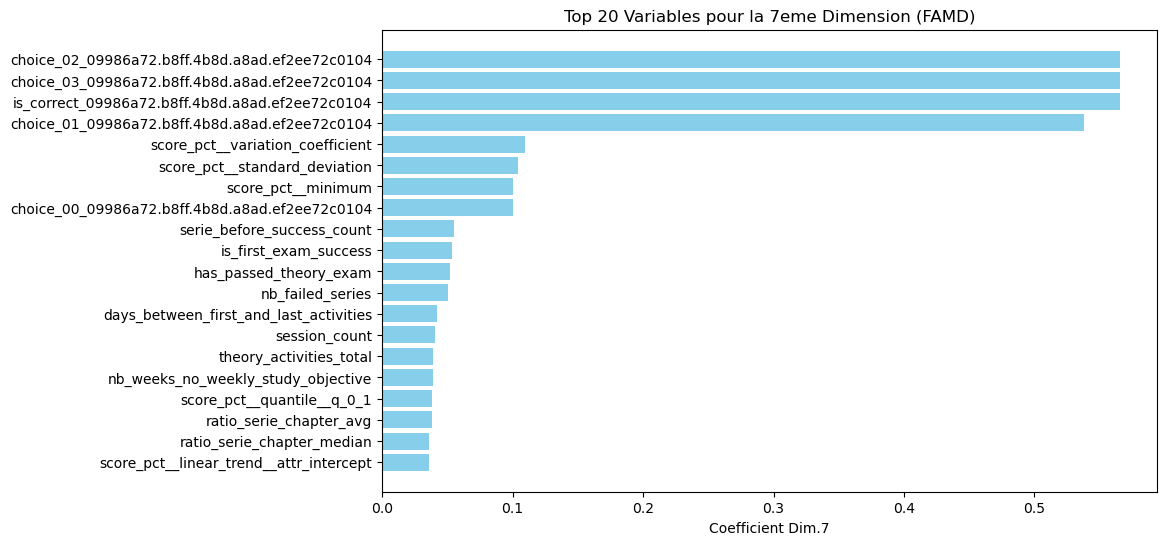

In [17]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.7
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim7_variables['Variable'], top_20_dim7_variables['Coefficient_Dim7'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.7')
plt.title('Top 20 Variables pour la 7eme Dimension (FAMD)')
plt.show()

---
### Dimension 7 :

- **Variables dominantes** : Les choix effectués par l'utilisateur (choice_01, choice_02, choice_03...); La réussite aux examens théoriques et pratiques (is_correct, is_first_exam_success, has_passed_theory_exam); Les performances aux évaluations (score_pct_variation_coefficient, score_pct_standard_deviation, score_pct_minimum); L'historique des tentatives et des échecs (nb_failed_series, serie_before_success_count); L'activité et la fréquence d'étude (days_between_first_and_last_activities, nb_weeks_no_weekly_study_objective)  

- **interprétation** : Ce nom reflète à la fois les choix effectués, la performance aux examens et la manière dont l'utilisateur interagit avec le processus d'apprentissage.
- **Nom suggéré** : <u>**"Stratégies et performances d’apprentissage"** </u>

<br/>
---


<br/>
<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Auto Encoder </u>
</p>
<br/>

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de 30000 observations pour notre Auto-Encoder. 

In [ ]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche caché en encdeur et au niveau du décodeur
* Fonctions d'activation : **Linear** dans les couches de l'encodeur et **sigmoid** en décodeur 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


657/657 [==============================] - 2s 3ms/step


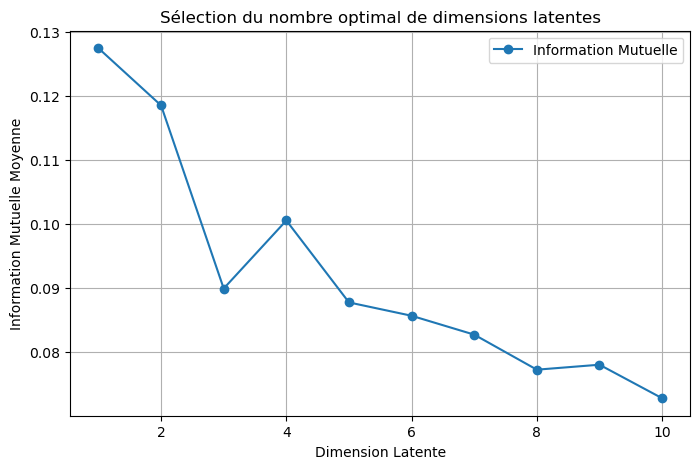

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.mean([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.mean(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Moyenne")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


L’analyse de la courbe obtenue montre une tendance générale décroissante de l’information mutuelle lorsque le nombre de dimensions latentes augmente. Cela est attendu, car en réduisant la dimensionnalité, nous éliminons progressivement certaines redondances mais aussi, potentiellement, des informations pertinentes.

Cependant, une observation plus fine révèle que :

* Entre 1 et 5 dimensions, l’information mutuelle diminue de manière marquée mais non linéaire.
* À partir de 5 dimensions, la décroissance devient plus progressive et régulière.
* L’ajout de dimensions au-delà de 5 n’apporte qu’un gain marginal en information mutuelle, suggérant que l’information restante est soit moins pertinente, soit redondante.

Nous choissons donc la valeur 5 pour la dimension de l'espace latent. 

Ce choix garantit un équilibre optimal entre compression et préservation d’information, permettant ainsi d’assurer une représentation efficace et compacte des données tout en évitant des dimensions inutiles.

L’étape suivante consiste à valider ce choix à l’aide de l’erreur de reconstruction, pour s’assurer que l’information capturée par ces 5 dimensions latentes est suffisante pour une bonne qualité de reconstruction des données originales.

In [2]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 5

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# Encodeur
Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


NameError: name 'base_AE' is not defined

Nous obtenons une erreur de reconstruction égale à 0.0328. Ce qui indique que l'autoencodeur parvient à reconstruire les données d'origine avec une précision raisonnable. Nous maintenons donc 5 comme dimension de l'espace latent. 

Aussi Le graphique précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=5 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=5 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

Nous allons maintenant passer à l'interprétation des nos 5 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. Ce effet sera utiliser pour déterminer quelles variables de départ influencent le plus quelle variable latente 

In [ ]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

In [ ]:
# # Vérification de la structure des valeurs SHAP
# print(f"Shape of shap_values: {len(shap_values)} dimensions latentes.")
# print(f"Shape of shap_values for first latent variable: {shap_values[0].shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(np.shape(shap_values))

In [ ]:
import pandas as pd

# Pour chaque dimension latente
for i in range(5):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(10))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              4.033124
is_first_exam_success_2                              2.977121
pct_no_objective_weeks                               2.670113
pct_study_objective_not_reached                      2.494268
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.286206
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.266252
prendre_quitter_vehicule_number_of_activities        1.855797
has_passed_theory_exam_1                             1.825285
autres_usagers_number_of_activities                  1.779124
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    1.730351
dtype: float64
Les variables les plus influentes pour la 2-ème dimension latente:
choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.502550
is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0    3.447411
choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.391110
is_first_exam_success_1                      

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes. Mais cette sortie serait plus intéressante sous forme de graphique.

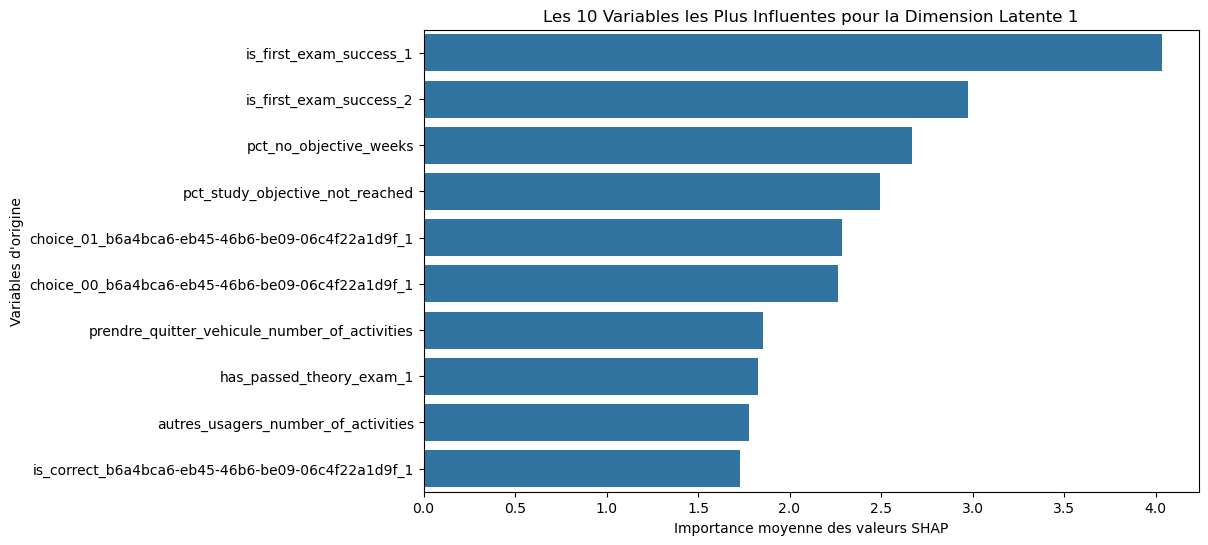

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=0 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension reflète la **préparation du candidat** et ses **performances initiales** dans le cadre de l'examen de permis. Les variables clés sont :

* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Indique si le candidat a réussi son premier examen.  
* **Manque d'objectifs d’étude** (pct_no_objective_weeks) : Montre si le candidat n'a pas d'objectifs clairs pendant sa préparation.  
* **Objectifs d’étude non atteints** (pct_study_objective_not_reached) : Mesure les objectifs d’étude non réalisés.  
* **Réponses aux questions d'examen** (choice_01_..., choice_00_...) : Indique les réponses correctes ou incorrectes aux questions.  
* **Activités pratiques de conduite** (prendre_quitter_vehicule_number_of_activities) : Nombre d'activités pratiques réalisées.  
* **Réussite à l'examen théorique** (has_passed_theory_exam_1) : Indique si le candidat a réussi l'examen théorique.  
* **Interactions avec d'autres usagers** (autres_usagers_number_of_activities) : Mesure l'expérience avec d'autres conducteurs.

La dimension évalue **la préparation et la réussite initiale** du candidat, en tenant compte de ses performances théoriques et pratiques, ainsi que de son engagement dans la préparation.


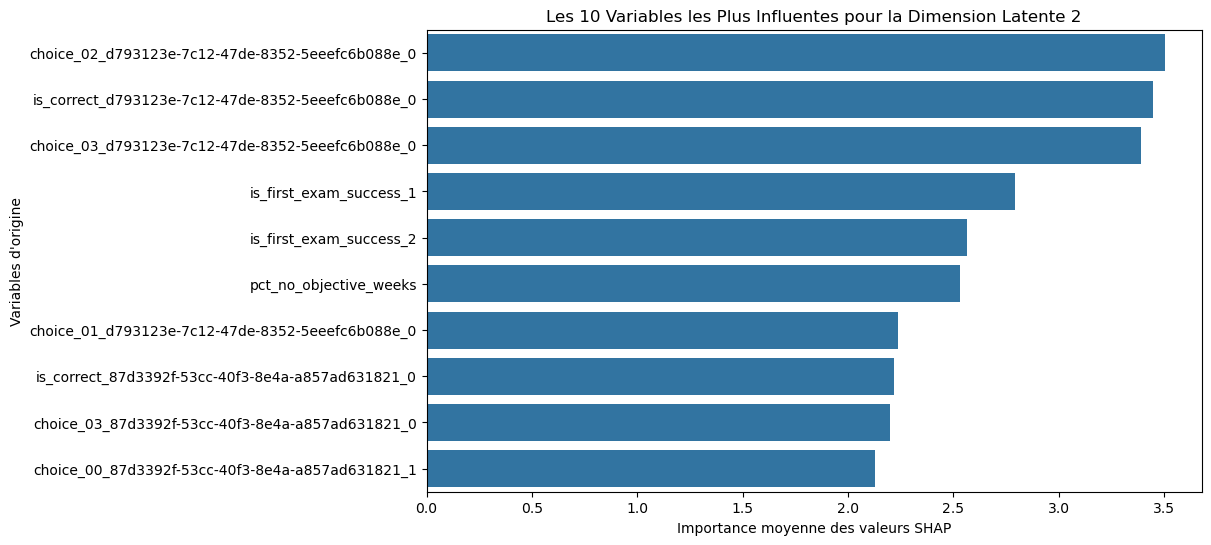

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=1 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble évaluer la **compréhension théorique** du candidat ainsi que sa **réaction aux questions spécifiques** du test. Les variables les plus influentes sont :

* **Réponses incorrectes aux questions spécifiques** (choice_02_..., choice_03_...) : Ces variables montrent les mauvaises réponses données aux questions du test. Cela reflète des **difficultés théoriques** ou un manque de préparation pour certains types de questions.
* **Exactitude des réponses spécifiques** (is_correct_...) : Indique si les réponses aux questions spécifiques étaient correctes ou non, ce qui montre l’**exactitude** du candidat dans la compréhension théorique.
* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Bien que déjà mentionnée, ici elle peut refléter la **compréhension théorique** du candidat, surtout par rapport à des erreurs spécifiques.


La **dimension latente 2** se concentre sur la **performance théorique** du candidat, en mettant en lumière ses **réponses correctes ou incorrectes** aux questions spécifiques du test et ses erreurs fréquentes, ce qui donne un aperçu de ses **difficultés théoriques**.


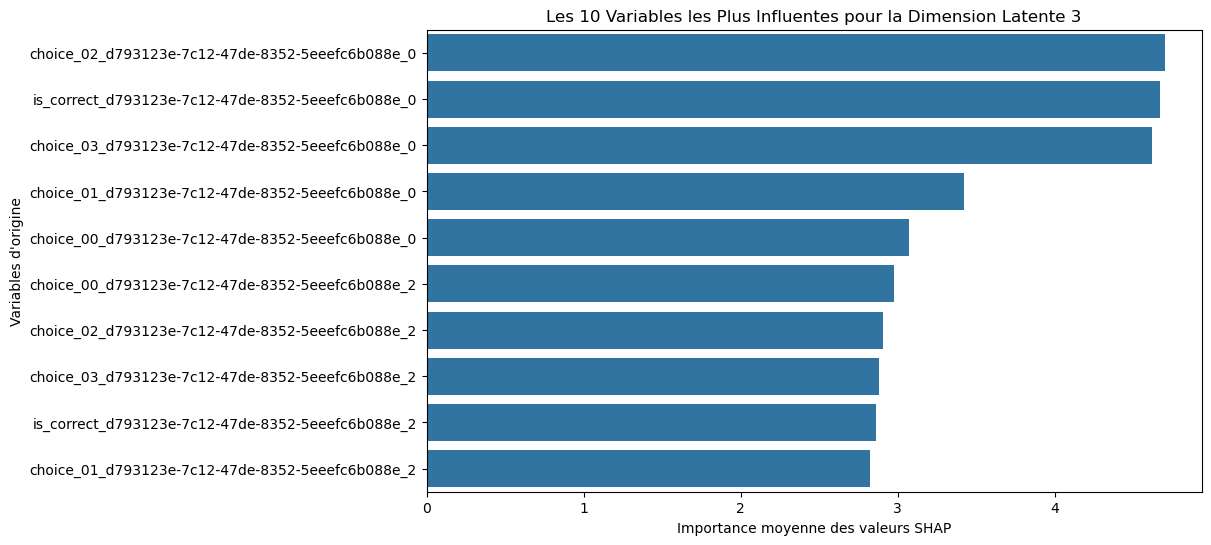

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=2 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble capturer la **sensibilité du candidat aux questions difficiles ou pièges** dans l'examen théorique.  Les variables clés sont :   
1. **Échecs aux mêmes questions spécifiques** (choice_02_..., choice_03_..., choice_01_..., is_correct_...) : Indique que certaines questions reviennent souvent parmi les erreurs du candidat.  
2. **Présence d’options "Non Renseigné"** (choice_00_..._2, choice_02_..._2, etc.) : Le candidat n’a peut-être pas répondu ou a hésité, suggérant une **incertitude face aux questions complexes**.  

La **dimension latente 3** reflète la **difficulté du candidat avec les questions théoriques complexes**, particulièrement celles qui induisent en erreur ou demandent une compréhension plus fine des règles. Cela peut indiquer un manque de confiance ou une hésitation face aux pièges du test.  


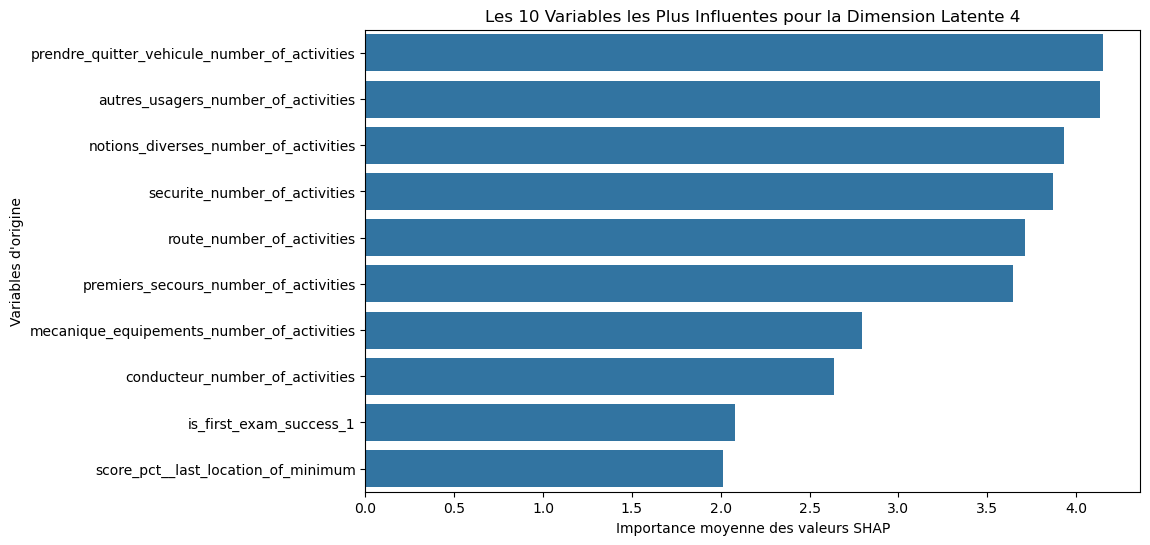

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=3 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()



Cette dimension semble refléter **l'implication du candidat dans les différentes catégories d’exercices pratiques**.  Les variables clés sont :  
1. **Nombre d’activités réalisées** (prendre_quitter_vehicule_number_of_activities, route_number_of_activities, securite_number_of_activities, etc.) : Indique le volume d’exercices effectués dans différents domaines.  
2. **Thèmes couverts** (mécanique, premiers secours, autres usagers, etc.) :  Montre si le candidat a exploré plusieurs aspects du code et de la conduite.  
3. **Succès au premier examen théorique** (is_first_exam_success_1) :  Une corrélation avec la réussite suggère que l'engagement pratique peut influencer les performances théoriques.  

La **dimension latente 4** représente **l’implication du candidat dans la formation pratique** et sa diversité d’exercices. Un score élevé ici pourrait indiquer un candidat **sérieux et appliqué** dans son apprentissage.  


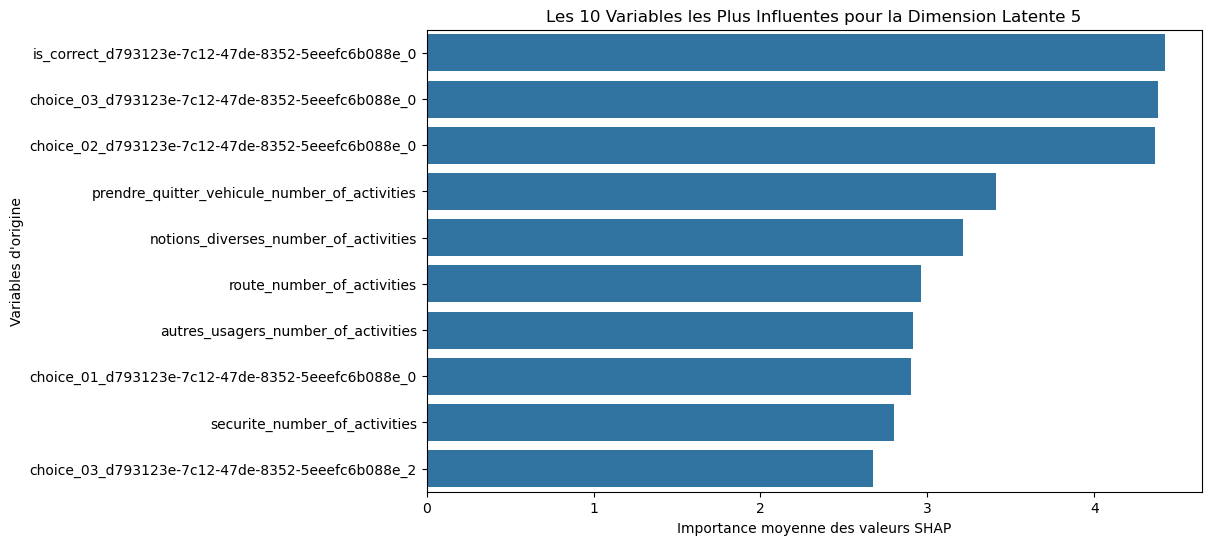

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=4 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble réfléter la **Performance sur des Questions Spécifiques et Expérience Pratique**  

Les variables clés sont :  
1. **Réponses correctes sur des questions spécifiques** (is_correct_d793123e…, choice_03…, choice_02…) :  Indique si le candidat a bien répondu à certaines questions du test.  
2. **Nombre d’activités pratiques** (prendre_quitter_vehicule_number_of_activities, notions_diverses_number_of_activities, route_number_of_activities, etc.) :  Reflète l'expérience accumulée dans différents aspects de la conduite.  

Cette **dimension latente 5** semble capturer **la capacité à répondre correctement à des questions ciblées tout en ayant une certaine expérience pratique**. Un score élevé peut refléter un candidat **qui combine théorie et application**.  



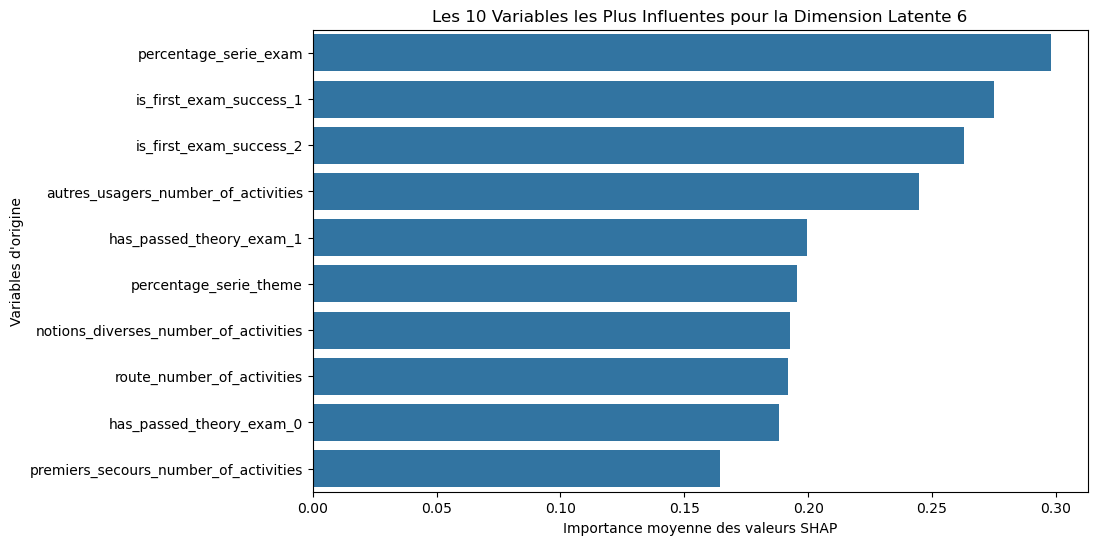

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=5 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette sixième dimension latente semble capturer des aspects liés à la progression générale des candidats dans leur préparation au permis de conduire, notamment leur réussite aux examens et leur participation à diverses activités pratiques. La variable *percentage_serie_exam* indique que cette dimension est en partie influencée par la quantité de séries d’examens suivies, ce qui suggère une relation avec l’engagement dans les tests.  

Les variables *is_first_exam_success_1* et *is_first_exam_success_2* montrent que la réussite au premier examen, ou l’absence de renseignement sur celui-ci, joue un rôle important dans cette dimension, avec une distinction claire entre ceux qui réussissent dès la première tentative et ceux qui ne l’ont pas encore passé. L’influence de *has_passed_theory_exam_1* et *has_passed_theory_exam_0* montre également une corrélation avec la réussite ou l’échec aux examens théoriques. 

Les activités pratiques, telles que *autres_usagers_number_of_activities*, *route_number_of_activities*, et *premiers_secours_number_of_activities*, révèlent que cette dimension intègre également la diversité des expériences pratiques suivies, notamment celles liées à la circulation et à la sécurité routière. Cela suggère que la dimension latente pourrait refléter un candidat ayant une préparation plus équilibrée, combinant théorie et pratique, et ayant un taux de réussite plus élevé en conséquence.

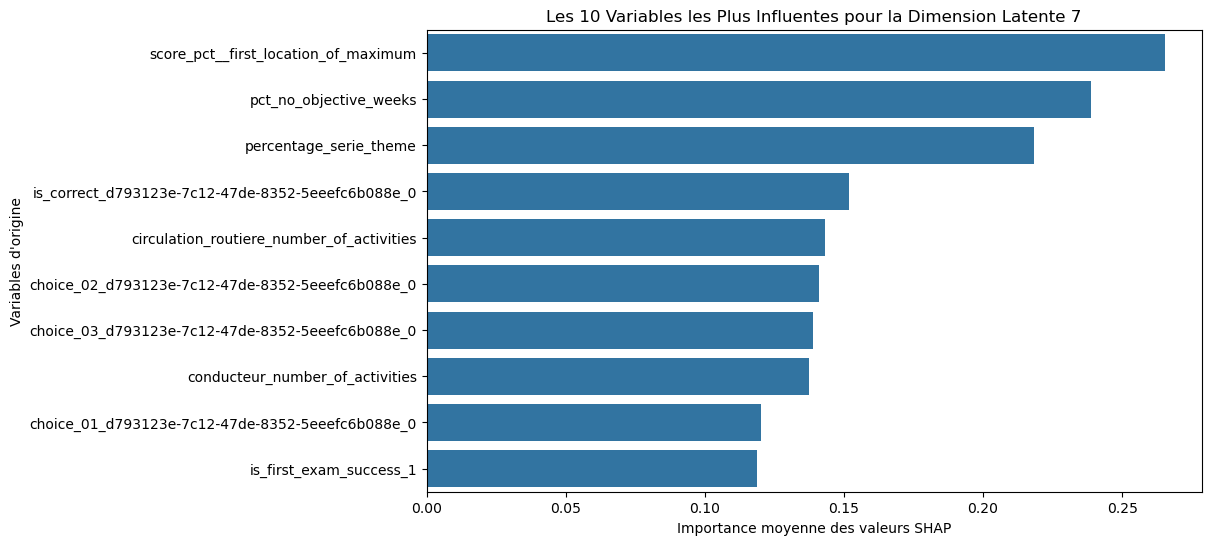

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=6 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette septième dimension latente semble être centrée sur la performance et l'engagement dans la préparation, en particulier en relation avec les tests pratiques et théoriques. La variable *score_pct__first_location_of_maximum* suggère que cette dimension capte des éléments de la performance des candidats, notamment les moments où ils obtiennent leurs meilleurs scores dans le test. Cela peut indiquer une dimension où la maîtrise de certaines compétences, comme les tests de connaissances spécifiques, joue un rôle clé.

Les variables *pct_no_objective_weeks* et *percentage_serie_theme* montrent un lien avec l'organisation et la structure de la préparation, suggérant que les candidats ayant un plan d'étude plus rigoureux pourraient se retrouver dans cette dimension. La présence des variables liées aux activités pratiques (*circulation_routiere_number_of_activities* et *conducteur_number_of_activities*) indique que l'engagement dans des pratiques concrètes est également un facteur influent dans cette dimension, peut-être en lien avec l'apprentissage de la conduite elle-même.

Les choix de réponses aux tests (*choice_XX_d793123e-7c12-47de-8352-5eeefc6b088e_0*) et la variable *is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0* montrent que cette dimension est également liée à la capacité des candidats à répondre correctement aux questions des examens. Enfin, *is_first_exam_success_1* indique que cette dimension reflète probablement un groupe de candidats qui ont réussi le premier examen, suggérant que la dimension latente capte ceux qui sont plus susceptibles de réussir dès la première tentative.

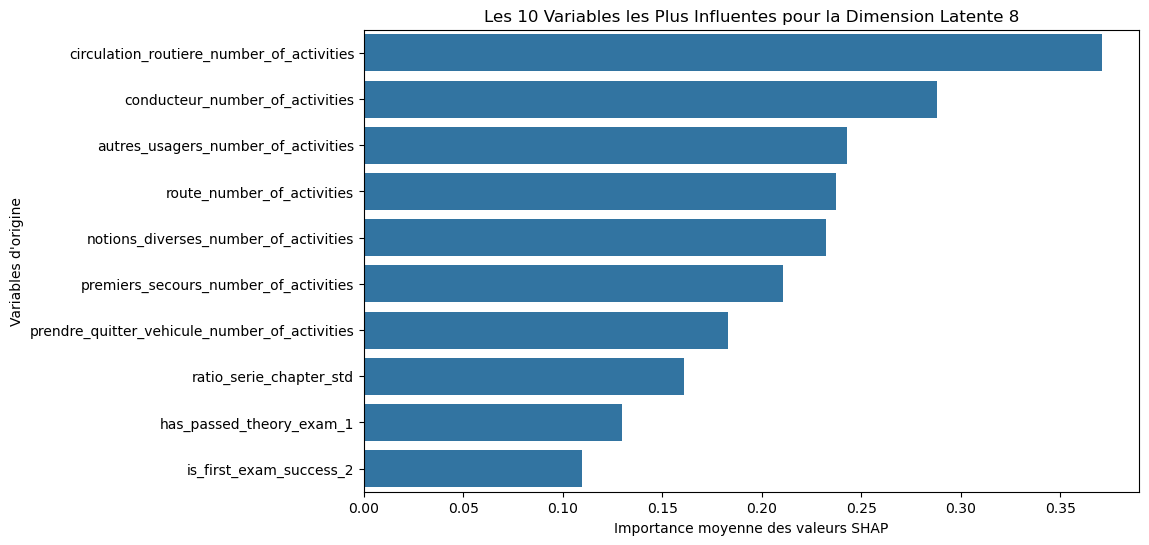

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=7 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette huitième dimension latente semble fortement axée sur l’implication pratique des candidats dans la préparation au permis de conduire. Les variables *circulation_routiere_number_of_activities*, *conducteur_number_of_activities*, et *route_number_of_activities* indiquent que la pratique de la conduite, l’apprentissage de la circulation routière, et l’implication dans des activités liées à la route sont des éléments clés dans cette dimension. Cela suggère que cette dimension représente les candidats qui s’engagent activement dans des expériences de conduite et des formations pratiques.

L’influence de *notions_diverses_number_of_activities* et *premiers_secours_number_of_activities* indique aussi que des connaissances plus larges et des formations en sécurité, telles que les premiers secours, jouent un rôle dans cette dimension, suggérant une préparation plus complète. *prendre_quitter_vehicule_number_of_activities* pourrait être lié aux pratiques concernant la gestion du véhicule, telles que l'entrée et la sortie du véhicule dans des contextes spécifiques. 

Le *ratio_serie_chapter_std* montre que cette dimension inclut aussi des candidats ayant un parcours d’étude plus varié, avec des différences dans la répartition des chapitres d'étude. Les variables *has_passed_theory_exam_1* et *is_first_exam_success_2* ajoutent des éléments de performance théorique et de statut de réussite, indiquant que cette dimension peut aussi inclure des candidats ayant passé leur examen théorique, mais avec un éventuel retard ou un échec à la première tentative. En somme, cette dimension semble capturer l’engagement pratique et la diversité des expériences dans la préparation au permis.

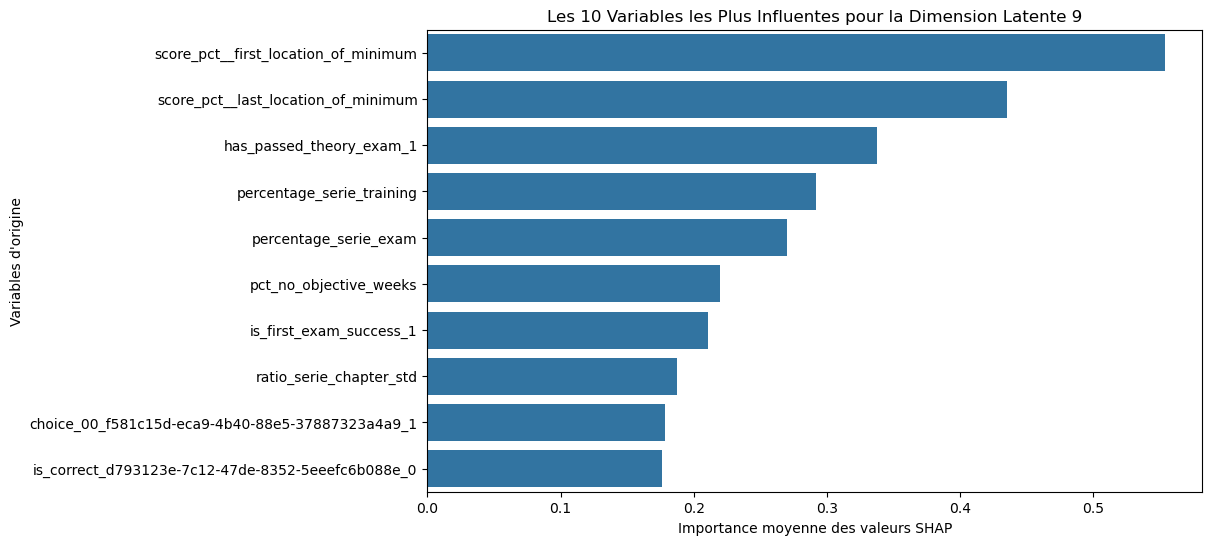

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=8 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette neuvième dimension latente semble être centrée sur les aspects liés aux résultats des tests, à la performance dans les séries d'examens et à la préparation théorique. Les variables *score_pct__first_location_of_minimum* et *score_pct__last_location_of_minimum* suggèrent que cette dimension capte des aspects de la performance des candidats en termes de scores les plus bas dans les tests, ce qui pourrait indiquer des difficultés dans certaines parties de l'examen ou une tendance à l'échec dans certaines sections spécifiques.

Les variables *has_passed_theory_exam_1* et *is_first_exam_success_1* confirment que cette dimension est liée à ceux qui ont réussi l'examen théorique, avec une distinction pour ceux qui ont réussi dès la première tentative. L'influence de *percentage_serie_training* et *percentage_serie_exam* indique que l'engagement dans la préparation (en termes de formation et de séries d'examens) a un impact important sur cette dimension, suggérant que les candidats ayant suivi une préparation plus approfondie sont mieux représentés dans cette dimension.

*PCT_no_objective_weeks* indique que l'absence d'objectifs précis dans la préparation pourrait aussi avoir un impact, bien que moins fort. La variable *ratio_serie_chapter_std* montre que cette dimension reflète aussi la variabilité dans la manière dont les candidats répartissent leur temps et leurs efforts d'étude, avec des candidats ayant des parcours d'étude plus standardisés. Enfin, les variables *choice_00_f581c15d-eca9-4b40-88e5-37887323a4a9_1* et *is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0* montrent que cette dimension capture également l'influence des choix de réponses lors des tests et des bonnes réponses fournies, ce qui renforce l'idée que cette dimension est liée à la performance testée et à la préparation théorique.

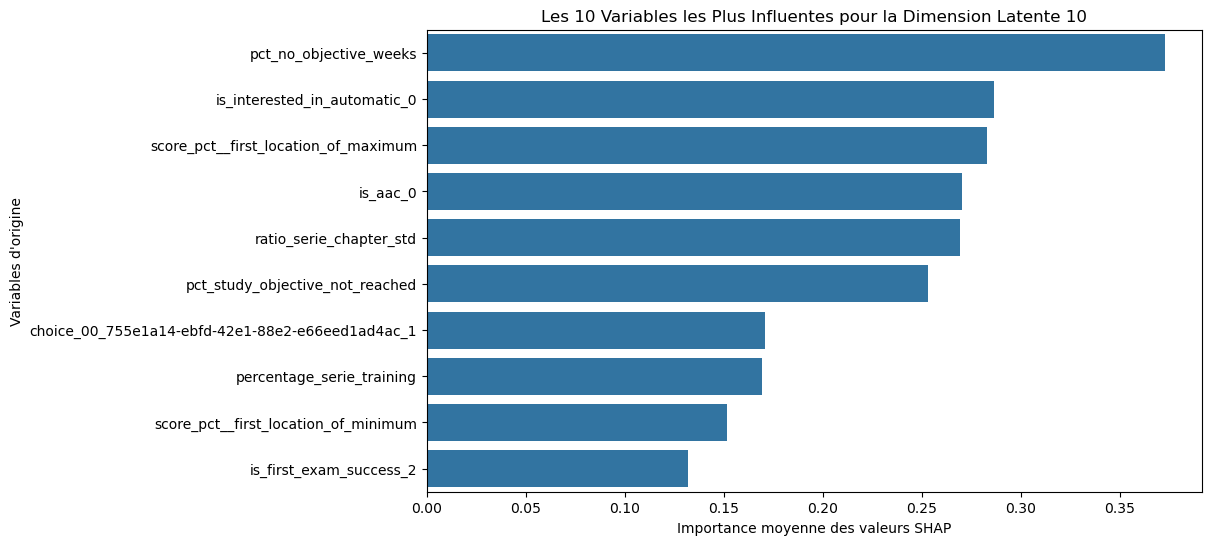

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=9 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


La dixième dimension latente semble refléter une combinaison de facteurs liés à la motivation personnelle, à la préparation à l'examen, et aux difficultés rencontrées dans le parcours d’apprentissage. 

*PCT_no_objective_weeks* indique que cette dimension est fortement influencée par les semaines passées sans objectifs clairs, suggérant que l'absence d'objectifs précis dans la préparation peut caractériser cette dimension. 

L'influence de *is_interested_in_automatic_0* et *is_aac_0* indique un lien avec les préférences personnelles et le statut par rapport à certaines formations ou tests, telles que la préférence pour un permis automatique ou un statut d'examen spécifique. Cela pourrait refléter un groupe de candidats ayant des choix ou des difficultés particuliers en matière de type de permis ou de préparation.

Les variables *score_pct__first_location_of_maximum* et *score_pct__first_location_of_minimum* montrent une attention particulière aux extrêmes de performance (les scores les plus élevés et les plus bas), suggérant que cette dimension est influencée par une variété de performances, incluant des pics de réussite ou des moments de difficulté. 

La variable *ratio_serie_chapter_std* met en évidence la diversité des parcours d’études, en particulier dans les chapitres de formation, et pourrait signifier que cette dimension représente des candidats ayant une approche d'étude moins homogène. En outre, *pct_study_objective_not_reached* reflète l'impact des objectifs d'étude non atteints, ce qui souligne une difficulté dans l'atteinte des objectifs fixés. Enfin, la faible influence de *is_first_exam_success_2* confirme que cette dimension peut inclure des candidats qui n'ont pas encore passé ou réussi le test.

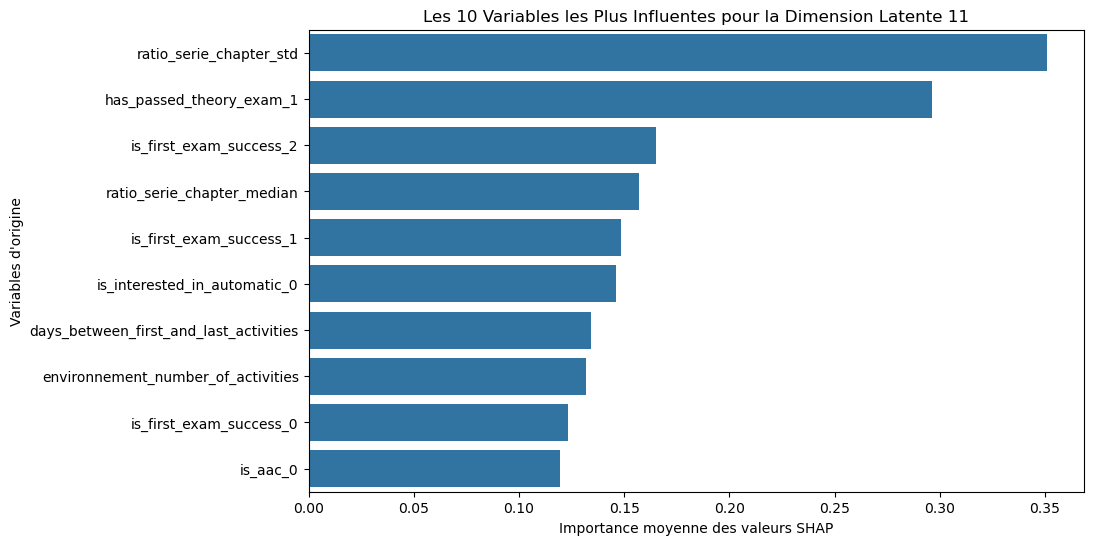

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=10 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


La onzième dimension latente semble être centrée sur les habitudes d'étude, le passage du test théorique et les résultats associés, tout en mettant en évidence l'impact de la préparation et des choix personnels.

La variable *ratio_serie_chapter_std* suggère que cette dimension est fortement influencée par la variabilité dans la manière dont les candidats répartissent leur temps et leurs efforts d’étude entre les différents chapitres de la série. Cela pourrait indiquer que les candidats de cette dimension ont des profils d’étude diversifiés, avec des variations dans leur approche d’apprentissage.

*has_passed_theory_exam_1* montre que cette dimension inclut une proportion importante de candidats ayant réussi l'examen théorique, et la variable *is_first_exam_success_1* confirme qu'une partie des individus ont réussi l'examen dès leur première tentative. Cependant, *is_first_exam_success_2* indique aussi la présence de ceux qui n'ont pas encore passé ou qui n’ont pas renseigné les résultats du test, ce qui montre une certaine hétérogénéité dans les candidats représentés par cette dimension.

La variable *ratio_serie_chapter_median* suggère également une influence de la répartition médiane du temps d’étude, ce qui peut signaler que les candidats de cette dimension ont un parcours d’étude relativement équilibré.

*is_interested_in_automatic_0* et *is_aac_0* montrent que cette dimension peut également inclure des préférences spécifiques en matière de type de permis ou de statut d’examen. De plus, *days_between_first_and_last_activities* met en évidence une dimension temporelle dans le processus d'étude, représentant des candidats qui peuvent avoir des périodes plus longues entre leurs premières et dernières activités, indiquant peut-être une approche plus étendue ou désorganisée.

Enfin, *environnement_number_of_activities* et *is_first_exam_success_0* montrent une influence de l'environnement d’étude et de ceux qui n’ont pas réussi à passer leur premier examen.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Comparaison des résultats obtenu par les 3 méthodes </u>
</p>
<br/>

Il peut être délicat de comparer les performances d'une ACP, d'une FAMD et d'un autoencodeur dans la mesure ou ces trois approches, bien que des méthodes de réduction de dimensions, utilisent des approches différentes. L'ACP est une méthode linéaire tandisque les autoencodeurs sont des réseaux de neurones qui peuvent modéliser des relations non linéaires.

Pour effectuer cette tâche, nous allons principalement utiliser l'erreur de reconstruction et l'information mutuelle. Ceci va nous permettre d'une part de voir qu'elle méthode reconstruit la base avec le moins d'erreur et d'autre part de quantifier à quel point les données reconstruites retiennent les mêmes informations que les données originales.
